# 🧠 LeetLLaMA: Empowering Programmers Through AI, Not Replacing Them

> _AI should not take away the joy of programming—let it become your pair programmer._

## 🔍 Overview

**LeetLLaMA** (short for **Leetcode Language Model Assessment & Mentorship Assistant**) is an open-source benchmark and platform initiative designed to evaluate and **empower** the use of lightweight, **cloud- and edge-deployable** large language models (LLMs) in helping humans—**not replacing them**—solve algorithmic problems interactively.

This benchmark is **not just another leaderboard**. It serves as a **proof of concept (PoC)** for a hands-on learning platform where programmers—especially beginners—can learn problem-solving in a meaningful, grounded, and explainable way, powered by small but capable LLMs.

---

## 🤖 Target LLMs

We benchmark several **small yet powerful open-weight LLMs** that are easily deployable on **local machines**, **edge devices**, or **lightweight cloud setups**:

- **LLaMA 3.2: 3B** – Meta’s latest offering for small-footprint performance  
- **Qwen 3: 4B** – High-performance multilingual LLM from Alibaba  
- **Phi 3: 3B** – Microsoft’s coding-friendly model with tight reasoning capability  
- **Gemma 3: 4B** – Google's compact model optimized for coding and tool use

These models represent a new wave of **cost-effective**, **private**, and **customizable** alternatives to traditional black-box LLMs.

---

## 🧠 LLM Grounding Strategies

We compare two primary **retrieval-augmented generation (RAG)** techniques for enhancing reasoning and factuality:

1. **Classic Vector RAG**  
   - Fast and simple  
   - Semantic retrieval over dense vector spaces

2. **Graph RAG** *(Non-ontological / Semantic Traversal)*  
   - Graph-based structure built from Python documentation & Leetcode solutions  
   - Enables **conceptual traversal**, **relational reasoning**, and **exploratory programming**

These configurations allow us to test how different grounding strategies influence LLM utility for step-by-step algorithmic reasoning.

---

## 📚 Knowledge Bases

We ground the models using two high-quality, **open-access corpora**:

1. **Leetcode Problem-Solution Dataset**  
   - Source: [greengerong/leetcode @ Hugging Face](https://huggingface.co/datasets/greengerong/leetcode)  
   - Curated problem statements + community-contributed solutions  

2. **Official Python 3 Documentation**  
   - The Python docs form the backbone of technical grounding  
   - Ideal for beginners and chosen as the **primary target language** due to Python’s simplicity, readability, and widespread use

---

## 🌱 Added Value

LeetLLaMA stands apart from traditional coding benchmarks in several key ways:

- 💡 **Human-Centric AI**: Models are evaluated for **interactive explainability**, **step-by-step mentoring**, and **pedagogical value**, not just accuracy
- 🧩 **Tool Use vs Delegation**: We advocate **AI-as-collaborator**, not code-outsourcing—akin to pair programming, not code replacement
- 🔌 **Lightweight Deployability**: Focused entirely on **resource-efficient**, **open-weight** models runnable on-prem or in your cloud VPC
- 🔬 **Multi-dimensional Benchmarking**: Accuracy is just one axis. We assess:  
  - Reasoning quality  
  - Grounding faithfulness  
  - Educational clarity  
  - Token and runtime efficiency

---

## 🧪 Platform PoC

Alongside the benchmark, we’re releasing a **minimal but extensible open-source platform** that demonstrates:

- 🔎 Integrated Vector + Graph RAG retrieval pipelines  
- 📎 Leetcode-style UI with contextual explainers  
- 🧠 Multi-model comparison interface (switch models on the fly)  
- 🧪 Plug-and-play architecture for testing new grounding or ranking methods

The platform aims to inspire **educators, researchers, and independent developers** to explore how **LLMs can teach programming**, not automate it away.

---

## 🚀 Get Involved

If you're interested in the intersection of **AI x Education x Developer Tools**, LeetLLaMA is your playground. Contributions welcome across:

- 🧠 Model evaluations  
- 🌐 Grounding & indexing pipelines  
- 🛠 Front-end interface for learning interaction  
- 📊 Visualization of reasoning paths (especially for Graph RAG)

---

## 📌 Final Thought

> _"The best way to learn is to teach."_

With LeetLLaMA, LLMs aren't just solving problems—they're **teaching you how**. Let’s build tools that **elevate programmers**, not erase them.

# Populating the Knowledge Bases

The first order of buisness is that of ***populating the knowledge bases***, by processing the data accordingly and then storing them in the *required* way in the respective *database*

---

In [115]:
# Process the Leetcode Problem - Solution dataset and load it into the Vector Store (Classic RAG knowledge base)
import os
import pandas as pd
from tqdm import tqdm
from pymilvus import (
    connections, FieldSchema, CollectionSchema, DataType, Collection,
    utility
)
from transformers import AutoTokenizer, AutoModel
import torch

MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
COLLECTION_NAME = "leetcode_kb"

# Connect to Milvus
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)

# 1. Load dataset
df = pd.read_json("hf://datasets/greengerong/leetcode/leetcode-train.jsonl", lines=True)
subset_df = df[["title", "content", "python"]]

# 2. Load embedding model and tokenizer
model_name = "BAAI/bge-large-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).cuda()
model.eval()

# 3. Get embedding dimension dynamically from model output
with torch.no_grad():
    dummy_input = tokenizer("dummy input", return_tensors="pt").to("cuda")
    dummy_output = model(**dummy_input)
    if hasattr(dummy_output, "pooler_output"):
        embedding_dim = dummy_output.pooler_output.shape[-1]
    else:
        embedding_dim = dummy_output.last_hidden_state.shape[-1]

# 4. Drop collection if it exists
if utility.has_collection(COLLECTION_NAME):
    print(f"Dropping existing collection '{COLLECTION_NAME}'...")
    utility.drop_collection(COLLECTION_NAME)

# 5. Define schema with text field added
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=embedding_dim),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535)  # max_length can be adjusted
]
schema = CollectionSchema(fields=fields, description="LeetCode QA embeddings with text")

# 6. Create collection
collection = Collection(name=COLLECTION_NAME, schema=schema)

# 7. Create FAISS-GPU index on embedding
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "IP",
    "params": {"nlist": 128},
    "device": "gpu"
}
print(f"Creating FAISS index on collection '{COLLECTION_NAME}'...")
collection.create_index(field_name="embedding", index_params=index_params)

# 8. Load collection into memory
collection.load()

# Helper: convert a row into Markdown
def create_markdown(row):
    title = row["title"]
    content = row["content"]
    python_code = row["python"]
    md = f"# {title}\n\n"
    md += f"## Content\n\n{content}\n\n"
    md += f"## Python Solution\n\n```python\n{python_code}\n```\n"
    return md

# Helper: generate embedding
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        if hasattr(outputs, "pooler_output"):
            embedding = outputs.pooler_output
        else:
            embedding = outputs.last_hidden_state.mean(dim=1)
        return embedding.cpu().numpy()[0]

# 9. Embed and insert data into Milvus with tqdm status bar
ids = []
embeddings = []
texts = []

print("Embedding and inserting documents into Milvus...")
for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="Processing"):
    md_text = create_markdown(row)
    emb = embed_text(md_text)
    ids.append(idx)
    embeddings.append(emb)
    texts.append(md_text)

collection.insert([ids, embeddings, texts])
collection.flush()

print(f"✅ Inserted {len(ids)} entries into Milvus collection '{COLLECTION_NAME}'")

Dropping existing collection 'leetcode_kb'...
Creating FAISS index on collection 'leetcode_kb'...
Embedding and inserting documents into Milvus...


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2360/2360 [01:12<00:00, 32.33it/s]


✅ Inserted 2360 entries into Milvus collection 'leetcode_kb'


In [117]:
# Scrape the official Python 3 documentation
import nest_asyncio
nest_asyncio.apply()

import asyncio
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig
from crawl4ai.content_scraping_strategy import LXMLWebScrapingStrategy
from crawl4ai.deep_crawling import BFSDeepCrawlStrategy
from crawl4ai.deep_crawling.filters import (
    FilterChain,
    DomainFilter,
    URLPatternFilter
)

# Main scraping function
async def main():
    filter_chain = FilterChain([
        DomainFilter(allowed_domains=["docs.python.org"]),
        URLPatternFilter(patterns=[r"^https://docs\.python\.org/3\.13/reference/"])
    ])

    crawl_config = CrawlerRunConfig(
        deep_crawl_strategy=BFSDeepCrawlStrategy(max_depth=2, include_external=False, filter_chain=filter_chain),
        scraping_strategy=LXMLWebScrapingStrategy(),
        target_elements=["section"],
        excluded_tags=["nav", "form", "header", "footer"]
    )

    crawl_config_single_page = CrawlerRunConfig(
        deep_crawl_strategy=BFSDeepCrawlStrategy(max_depth=1, include_external=False, filter_chain=filter_chain),
        scraping_strategy=LXMLWebScrapingStrategy(),
        target_elements=["section"],
        excluded_tags=["nav", "form", "header", "footer"]
    )

    # Target Python docs URLs
    target_urls = [
        "https://docs.python.org/3.13/reference/",
        "https://docs.python.org/3.15/library/stdtypes.html"
    ]

    scraped_results = []

    print("📘 Scraping first target URL...")
    async with AsyncWebCrawler() as crawler:
        results = await crawler.arun(
            url=target_urls[0],
            config=crawl_config
        )
        scraped_results.append(results)

    print("📙 Scraping second target URL...")
    async with AsyncWebCrawler() as crawler:
        results = await crawler.arun(
            url=target_urls[1],
            config=crawl_config_single_page
        )
        scraped_results.append(results)

    print("✅ Done scraping.")
    
    return scraped_results 
    

scraped_results = await main()

📘 Scraping first target URL...


[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://docs.python.org/3.13/reference/                                                              |
✓ | ⏱: 1.20s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/                                                              |
✓ | ⏱: 0.04s 

[COMPLETE] ● https://docs.python.org/3.13/reference/                                                              |
✓ | ⏱: 1.25s 

[FETCH]... ↓ https://docs.python.org/3.13/reference                                                               |
✓ | ⏱: 0.45s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference                                                               |
✓ | ⏱: 0.02s 

[COMPLETE] ● https://docs.python.org/3.13/reference                                                               |
✓ | ⏱: 0.48s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html                                           |
✓ | ⏱: 0.97s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html                                           |
✓ | ⏱: 0.06s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html                                           |
✓ | ⏱: 1.04s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html                                              |
✓ | ⏱: 1.26s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html                                              |
✓ | ⏱: 0.28s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html                                              |
✓ | ⏱: 1.54s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html                                           |
✓ | ⏱: 1.56s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html                                           |
✓ | ⏱: 0.28s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html                                           |
✓ | ⏱: 1.85s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html                                                |
✓ | ⏱: 2.04s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html                                                |
✓ | ⏱: 0.78s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html                                                |
✓ | ⏱: 2.82s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/toplevel_components.html                                      |
✓ | ⏱: 2.48s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/toplevel_components.html                                      |
✓ | ⏱: 0.01s 

[COMPLETE] ● https://docs.python.org/3.13/reference/toplevel_components.html                                      |
✓ | ⏱: 2.50s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html                                             |
✓ | ⏱: 2.51s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html                                             |
✓ | ⏱: 0.11s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html                                             |
✓ | ⏱: 2.62s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html                                         |
✓ | ⏱: 2.62s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html                                         |
✓ | ⏱: 0.13s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html                                         |
✓ | ⏱: 2.75s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/grammar.html                                                  |
✓ | ⏱: 2.72s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/grammar.html                                                  |
✓ | ⏱: 0.06s 

[COMPLETE] ● https://docs.python.org/3.13/reference/grammar.html                                                  |
✓ | ⏱: 2.79s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html                                                   |
✓ | ⏱: 2.80s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html                                                   |
✓ | ⏱: 0.13s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html                                                   |
✓ | ⏱: 2.93s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/introduction.html                                             |
✓ | ⏱: 2.97s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/introduction.html                                             |
✓ | ⏱: 0.01s 

[COMPLETE] ● https://docs.python.org/3.13/reference/introduction.html                                             |
✓ | ⏱: 2.98s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/bugs.html                                                     |
✓ | ⏱: 0.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/bugs.html                                                     |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/bugs.html                                                     |
✓ | ⏱: 0.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/simple_stmts.html                         |
✓ | ⏱: 1.52s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/simple_stmts.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/simple_stmts.html                         |
✓ | ⏱: 1.53s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/expressions.html                          |
✓ | ⏱: 1.63s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/expressions.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/expressions.html                          |
✓ | ⏱: 1.64s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/toplevel_components.html                  |
✓ | ⏱: 1.63s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/toplevel_components.html                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/toplevel_components.html                  |
✓ | ⏱: 1.63s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/lexical_analysis.html                     |
✓ | ⏱: 1.66s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/lexical_analysis.html                     |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/lexical_analysis.html                     |
✓ | ⏱: 1.67s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/index.html                                |
✓ | ⏱: 1.62s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/index.html                                |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/index.html                                |
✓ | ⏱: 1.63s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/grammar.html                              |
✓ | ⏱: 1.62s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/grammar.html                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/grammar.html                              |
✓ | ⏱: 1.62s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/executionmodel.html                       |
✓ | ⏱: 1.60s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/executionmodel.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/executionmodel.html                       |
✓ | ⏱: 1.61s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/compound_stmts.html/datamodel.html                            |
✓ | ⏱: 1.58s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/compound_stmts.html/datamodel.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/compound_stmts.html/datamodel.html                            |
✓ | ⏱: 1.58s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/compound_stmts.html                            |
✓ | ⏱: 1.60s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/compound_stmts.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/compound_stmts.html                            |
✓ | ⏱: 1.61s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/c-api/typeobj.html                                            |
✓ | ⏱: 1.58s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/c-api/typeobj.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/c-api/typeobj.html                                            |
✓ | ⏱: 1.59s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/copyright.html                                                |
✓ | ⏱: 1.57s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/copyright.html                                                |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/copyright.html                                                |
✓ | ⏱: 1.58s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/contents.html                                                 |
✓ | ⏱: 1.56s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/contents.html                                                 |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/contents.html                                                 |
✓ | ⏱: 1.57s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/c-api/arg.html                                                |
✓ | ⏱: 1.20s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/c-api/arg.html                                                |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/c-api/arg.html                                                |
✓ | ⏱: 1.21s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/c-api/intro.html                                              |
✓ | ⏱: 1.21s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/c-api/intro.html                                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/c-api/intro.html                                              |
✓ | ⏱: 1.21s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/c-api/buffer.html                                             |
✓ | ⏱: 1.21s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/c-api/buffer.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/c-api/buffer.html                                             |
✓ | ⏱: 1.22s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/executionmodel.html                            |
✓ | ⏱: 0.45s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/executionmodel.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/executionmodel.html                            |
✓ | ⏱: 0.46s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/expressions.html                               |
✓ | ⏱: 0.61s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/expressions.html                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/expressions.html                               |
✓ | ⏱: 0.61s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/import.html                                    |
✓ | ⏱: 0.42s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/import.html                                    |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/import.html                                    |
✓ | ⏱: 0.42s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/lexical_analysis.html                          |
✓ | ⏱: 0.47s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/lexical_analysis.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/lexical_analysis.html                          |
✓ | ⏱: 0.48s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/index.html                                     |
✓ | ⏱: 0.47s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/index.html                                     |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/index.html                                     |
✓ | ⏱: 0.48s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/datamodel.html                            |
✓ | ⏱: 0.50s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/datamodel.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/datamodel.html                            |
✓ | ⏱: 0.51s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/compound_stmts.html                       |
✓ | ⏱: 0.59s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/compound_stmts.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/compound_stmts.html                       |
✓ | ⏱: 0.60s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/datamodel.html/simple_stmts.html                              |
✓ | ⏱: 0.63s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/datamodel.html/simple_stmts.html                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/datamodel.html/simple_stmts.html                              |
✓ | ⏱: 0.64s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/expressions.html                          |
✓ | ⏱: 0.54s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/expressions.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/expressions.html                          |
✓ | ⏱: 0.54s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/index.html                                   |
✓ | ⏱: 0.94s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/index.html                                   |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/index.html                                   |
✓ | ⏱: 0.95s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/import.html                                  |
✓ | ⏱: 1.20s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/import.html                                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/import.html                                  |
✓ | ⏱: 1.20s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/index.html                                |
✓ | ⏱: 1.42s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/index.html                                |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/index.html                                |
✓ | ⏱: 1.42s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/import.html                               |
✓ | ⏱: 1.41s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/import.html                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/import.html                               |
✓ | ⏱: 1.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/datamodel.html                               |
✓ | ⏱: 1.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/datamodel.html                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/datamodel.html                               |
✓ | ⏱: 1.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/executionmodel.html/simple_stmts.html                         |
✓ | ⏱: 1.39s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/executionmodel.html/simple_stmts.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/executionmodel.html/simple_stmts.html                         |
✓ | ⏱: 1.40s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/compound_stmts.html                          |
✓ | ⏱: 1.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/compound_stmts.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/compound_stmts.html                          |
✓ | ⏱: 1.40s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/grammar.html/index.html                                       |
✓ | ⏱: 1.46s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/grammar.html/index.html                                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/grammar.html/index.html                                       |
✓ | ⏱: 1.46s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/howto/annotations.html                                        |
✓ | ⏱: 1.51s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/howto/annotations.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/howto/annotations.html                                        |
✓ | ⏱: 1.51s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/grammar.html/toplevel_components.html                         |
✓ | ⏱: 1.54s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/grammar.html/toplevel_components.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/grammar.html/toplevel_components.html                         |
✓ | ⏱: 1.55s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/glossary.html                                                 |
✓ | ⏱: 1.54s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/glossary.html                                                 |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/glossary.html                                                 |
✓ | ⏱: 1.55s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/executionmodel.html                          |
✓ | ⏱: 1.34s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/executionmodel.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/executionmodel.html                          |
✓ | ⏱: 1.34s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/simple_stmts.html                            |
✓ | ⏱: 1.20s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/simple_stmts.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/simple_stmts.html                            |
✓ | ⏱: 1.21s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/faq/programming.html                                          |
✓ | ⏱: 1.20s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/faq/programming.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/faq/programming.html                                          |
✓ | ⏱: 1.20s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/genindex.html                                                 |
✓ | ⏱: 1.19s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/genindex.html                                                 |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/genindex.html                                                 |
✓ | ⏱: 1.20s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/expressions.html/lexical_analysis.html                        |
✓ | ⏱: 1.19s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/expressions.html/lexical_analysis.html                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/expressions.html/lexical_analysis.html                        |
✓ | ⏱: 1.19s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/datamodel.html                                    |
✓ | ⏱: 0.86s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/datamodel.html                                    |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/datamodel.html                                    |
✓ | ⏱: 0.86s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/howto/mro.html                                                |
✓ | ⏱: 0.79s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/howto/mro.html                                                |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/howto/mro.html                                                |
✓ | ⏱: 0.79s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/executionmodel.html                               |
✓ | ⏱: 0.42s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/executionmodel.html                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/executionmodel.html                               |
✓ | ⏱: 0.42s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/expressions.html                                  |
✓ | ⏱: 0.39s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/expressions.html                                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/expressions.html                                  |
✓ | ⏱: 0.40s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/introduction.html/lexical_analysis.html                       |
✓ | ⏱: 1.12s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/introduction.html/lexical_analysis.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/introduction.html/lexical_analysis.html                       |
✓ | ⏱: 1.12s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/toplevel_components.html                          |
✓ | ⏱: 1.27s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/toplevel_components.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/toplevel_components.html                          |
✓ | ⏱: 1.28s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/compound_stmts.html                     |
✓ | ⏱: 1.31s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/compound_stmts.html                     |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/compound_stmts.html                     |
✓ | ⏱: 1.31s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/datamodel.html                          |
✓ | ⏱: 1.30s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/datamodel.html                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/datamodel.html                          |
✓ | ⏱: 1.31s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/introduction.html/index.html                                  |
✓ | ⏱: 1.30s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/introduction.html/index.html                                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/introduction.html/index.html                                  |
✓ | ⏱: 1.30s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/index.html                                                    |
✓ | ⏱: 1.29s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/index.html                                                    |
✓ | ⏱: 0.02s 

[COMPLETE] ● https://docs.python.org/3.13/reference/index.html                                                    |
✓ | ⏱: 1.31s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/simple_stmts.html                                 |
✓ | ⏱: 1.27s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/simple_stmts.html                                 |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/simple_stmts.html                                 |
✓ | ⏱: 1.27s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/import.html/index.html                                        |
✓ | ⏱: 1.29s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/import.html/index.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/import.html/index.html                                        |
✓ | ⏱: 1.29s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/abc.html                                              |
✓ | ⏱: 0.86s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/abc.html                                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/abc.html                                              |
✓ | ⏱: 0.87s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/__future__.html                                       |
✓ | ⏱: 0.86s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/__future__.html                                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/__future__.html                                       |
✓ | ⏱: 0.87s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/__main__.html                                         |
✓ | ⏱: 0.88s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/__main__.html                                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/__main__.html                                         |
✓ | ⏱: 0.89s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/index.html                              |
✓ | ⏱: 0.82s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/index.html                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/index.html                              |
✓ | ⏱: 0.82s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/expressions.html                        |
✓ | ⏱: 0.82s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/expressions.html                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/expressions.html                        |
✓ | ⏱: 0.82s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/introduction.html                       |
✓ | ⏱: 0.63s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/introduction.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/introduction.html                       |
✓ | ⏱: 0.63s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/lexical_analysis.html/simple_stmts.html                       |
✓ | ⏱: 0.62s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/lexical_analysis.html/simple_stmts.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/lexical_analysis.html/simple_stmts.html                       |
✓ | ⏱: 0.63s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/array.html                                            |
✓ | ⏱: 0.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/array.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/array.html                                            |
✓ | ⏱: 0.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/collections.html                                      |
✓ | ⏱: 0.52s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/collections.html                                      |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/collections.html                                      |
✓ | ⏱: 0.52s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/constants.html                                        |
✓ | ⏱: 0.54s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/constants.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/constants.html                                        |
✓ | ⏱: 0.55s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/asyncio-future.html                                   |
✓ | ⏱: 0.55s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/asyncio-future.html                                   |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/asyncio-future.html                                   |
✓ | ⏱: 0.55s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/asyncio.html                                          |
✓ | ⏱: 0.49s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/asyncio.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/asyncio.html                                          |
✓ | ⏱: 0.49s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/builtins.html                                         |
✓ | ⏱: 0.43s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/builtins.html                                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/builtins.html                                         |
✓ | ⏱: 0.43s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/codecs.html                                           |
✓ | ⏱: 0.42s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/codecs.html                                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/codecs.html                                           |
✓ | ⏱: 0.42s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/collections.abc.html                                  |
✓ | ⏱: 0.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/collections.abc.html                                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/collections.abc.html                                  |
✓ | ⏱: 0.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/dbm.html                                              |
✓ | ⏱: 0.53s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/dbm.html                                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/dbm.html                                              |
✓ | ⏱: 0.53s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/decimal.html                                          |
✓ | ⏱: 0.73s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/decimal.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/decimal.html                                          |
✓ | ⏱: 0.74s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/copy.html                                             |
✓ | ⏱: 0.73s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/copy.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/copy.html                                             |
✓ | ⏱: 0.74s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/math.html                                             |
✓ | ⏱: 0.92s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/math.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/math.html                                             |
✓ | ⏱: 0.93s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/numbers.html                                          |
✓ | ⏱: 0.94s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/numbers.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/numbers.html                                          |
✓ | ⏱: 0.94s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/io.html                                               |
✓ | ⏱: 1.35s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/io.html                                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/io.html                                               |
✓ | ⏱: 1.36s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/inspect.html                                          |
✓ | ⏱: 1.45s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/inspect.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/inspect.html                                          |
✓ | ⏱: 1.45s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/fractions.html                                        |
✓ | ⏱: 1.51s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/fractions.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/fractions.html                                        |
✓ | ⏱: 1.51s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/functions.html                                        |
✓ | ⏱: 1.41s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/functions.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/functions.html                                        |
✓ | ⏱: 1.42s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/functools.html                                        |
✓ | ⏱: 1.43s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/functools.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/functools.html                                        |
✓ | ⏱: 1.44s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/index.html                                            |
✓ | ⏱: 1.50s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/index.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/index.html                                            |
✓ | ⏱: 1.50s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/enum.html                                             |
✓ | ⏱: 1.44s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/enum.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/enum.html                                             |
✓ | ⏱: 1.44s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/email.mime.html                                       |
✓ | ⏱: 1.51s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/email.mime.html                                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/email.mime.html                                       |
✓ | ⏱: 1.52s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/exceptions.html                                       |
✓ | ⏱: 1.55s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/exceptions.html                                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/exceptions.html                                       |
✓ | ⏱: 1.56s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/email.html                                            |
✓ | ⏱: 1.55s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/email.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/email.html                                            |
✓ | ⏱: 1.55s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/os.html                                               |
✓ | ⏱: 1.49s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/os.html                                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/os.html                                               |
✓ | ⏱: 1.50s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/importlib.html                                        |
✓ | ⏱: 1.15s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/importlib.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/importlib.html                                        |
✓ | ⏱: 1.16s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/gettext.html                                          |
✓ | ⏱: 1.17s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/gettext.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/gettext.html                                          |
✓ | ⏱: 1.18s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/operator.html                                         |
✓ | ⏱: 1.15s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/operator.html                                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/operator.html                                         |
✓ | ⏱: 1.15s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/gc.html                                               |
✓ | ⏱: 0.74s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/gc.html                                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/gc.html                                               |
✓ | ⏱: 0.75s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/site.html                                             |
✓ | ⏱: 0.41s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/site.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/site.html                                             |
✓ | ⏱: 0.41s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/socket.html                                           |
✓ | ⏱: 0.40s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/socket.html                                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/socket.html                                           |
✓ | ⏱: 0.40s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/stdtypes.html                                         |
✓ | ⏱: 0.83s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/stdtypes.html                                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/stdtypes.html                                         |
✓ | ⏱: 0.84s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/string.html                                           |
✓ | ⏱: 1.00s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/string.html                                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/string.html                                           |
✓ | ⏱: 1.01s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/weakref.html                                          |
✓ | ⏱: 1.09s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/weakref.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/weakref.html                                          |
✓ | ⏱: 1.10s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/unicodedata.html                                      |
✓ | ⏱: 1.09s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/unicodedata.html                                      |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/unicodedata.html                                      |
✓ | ⏱: 1.10s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/types.html                                            |
✓ | ⏱: 1.06s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/types.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/types.html                                            |
✓ | ⏱: 1.06s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/typing.html                                           |
✓ | ⏱: 1.08s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/typing.html                                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/typing.html                                           |
✓ | ⏱: 1.08s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/sys.html                                              |
✓ | ⏱: 1.01s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/sys.html                                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/sys.html                                              |
✓ | ⏱: 1.02s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/compound_stmts.html                         |
✓ | ⏱: 0.93s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/compound_stmts.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/compound_stmts.html                         |
✓ | ⏱: 0.94s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/py-modindex.html                                              |
✓ | ⏱: 0.98s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/py-modindex.html                                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/py-modindex.html                                              |
✓ | ⏱: 0.99s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/library/zipimport.html                                        |
✓ | ⏱: 0.98s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/library/zipimport.html                                        |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/library/zipimport.html                                        |
✓ | ⏱: 0.99s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/datamodel.html                              |
✓ | ⏱: 0.99s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/datamodel.html                              |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/datamodel.html                              |
✓ | ⏱: 0.99s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/import.html                                 |
✓ | ⏱: 0.94s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/import.html                                 |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/import.html                                 |
✓ | ⏱: 0.94s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/executionmodel.html                         |
✓ | ⏱: 0.99s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/executionmodel.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/executionmodel.html                         |
✓ | ⏱: 0.99s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/index.html                                  |
✓ | ⏱: 1.01s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/index.html                                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/index.html                                  |
✓ | ⏱: 1.01s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/expressions.html                            |
✓ | ⏱: 1.01s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/expressions.html                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/expressions.html                            |
✓ | ⏱: 1.01s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/toplevel_components.html/compound_stmts.html                  |
✓ | ⏱: 0.91s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/toplevel_components.html/compound_stmts.html                  |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/toplevel_components.html/compound_stmts.html                  |
✓ | ⏱: 0.91s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/simple_stmts.html/lexical_analysis.html                       |
✓ | ⏱: 0.96s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/simple_stmts.html/lexical_analysis.html                       |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/simple_stmts.html/lexical_analysis.html                       |
✓ | ⏱: 0.97s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/toplevel_components.html/expressions.html                     |
✓ | ⏱: 0.94s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/toplevel_components.html/expressions.html                     |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/toplevel_components.html/expressions.html                     |
✓ | ⏱: 0.95s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/whatsnew/3.3.html                                             |
✓ | ⏱: 0.95s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/whatsnew/3.3.html                                             |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/whatsnew/3.3.html                                             |
✓ | ⏱: 0.96s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/toplevel_components.html/index.html                           |
✓ | ⏱: 0.83s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/toplevel_components.html/index.html                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/toplevel_components.html/index.html                           |
✓ | ⏱: 0.83s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/toplevel_components.html/grammar.html                         |
✓ | ⏱: 1.13s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/toplevel_components.html/grammar.html                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/toplevel_components.html/grammar.html                         |
✓ | ⏱: 1.13s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/tutorial/errors.html                                          |
✓ | ⏱: 0.45s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/tutorial/errors.html                                          |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/tutorial/errors.html                                          |
✓ | ⏱: 0.46s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/tutorial/classes.html                                         |
✓ | ⏱: 0.45s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/tutorial/classes.html                                         |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/tutorial/classes.html                                         |
✓ | ⏱: 0.45s 

[FETCH]... ↓ https://docs.python.org/3.13/reference/using/cmdline.html                                            |
✓ | ⏱: 0.41s 

[SCRAPE].. ◆ https://docs.python.org/3.13/reference/using/cmdline.html                                            |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://docs.python.org/3.13/reference/using/cmdline.html                                            |
✓ | ⏱: 0.41s 

📙 Scraping second target URL...


[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://docs.python.org/3.15/library/stdtypes.html                                                   |
✓ | ⏱: 1.37s 

[SCRAPE].. ◆ https://docs.python.org/3.15/library/stdtypes.html                                                   |
✓ | ⏱: 1.19s 

[COMPLETE] ● https://docs.python.org/3.15/library/stdtypes.html                                                   |
✓ | ⏱: 2.56s 

✅ Done scraping.


In [118]:
# Loading up the scraped results into the Vector Store (Classic RAG)
from pymilvus import connections, FieldSchema, CollectionSchema, Collection, DataType, utility
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import re

# --- Config ---
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
COLLECTION_NAME = "pydocs_kb"
MODEL_NAME = "BAAI/bge-large-en"

# --- Connect to Milvus ---
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)

# --- Load embedding model ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).cuda()
model.eval()

# --- Get embedding dimension ---
with torch.no_grad():
    dummy_input = tokenizer("dummy input", return_tensors="pt").to("cuda")
    dummy_output = model(**dummy_input)
    embedding_dim = (
        dummy_output.pooler_output.shape[-1]
        if hasattr(dummy_output, "pooler_output")
        else dummy_output.last_hidden_state.shape[-1]
    )

# --- Recreate Milvus collection with text field ---
if utility.has_collection(COLLECTION_NAME):
    print(f"🗑️ Dropping existing collection '{COLLECTION_NAME}'...")
    utility.drop_collection(COLLECTION_NAME)

fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=embedding_dim),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535)  # text field added
]
schema = CollectionSchema(fields=fields, description="Python Docs Embeddings with text")
collection = Collection(name=COLLECTION_NAME, schema=schema)

# --- Create GPU Index ---
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "IP",
    "params": {"nlist": 128},
    "device": "gpu"
}
collection.create_index(field_name="embedding", index_params=index_params)
collection.load()

# --- Embedding Helper ---
def embed_text(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = (
            outputs.pooler_output
            if hasattr(outputs, "pooler_output")
            else outputs.last_hidden_state.mean(dim=1)
        )
    return embedding.cpu().numpy()[0]

# --- Markdown splitter ---
def split_markdown_by_headers(markdown_text: str) -> list[str]:
    sections = re.split(r'(## .+)', markdown_text)
    chunks = []
    for i in range(1, len(sections), 2):
        header = sections[i].strip()
        content = sections[i+1].strip() if (i+1) < len(sections) else ""
        chunk = f"{header}\n\n{content}".strip()
        chunks.append(chunk)
    return chunks

# --- Flatten and process ---
flattened_markdown_chunks = []
for page_result in scraped_results:
    for result in page_result:
        markdown_str = result.markdown.strip()
        if markdown_str:
            chunks = split_markdown_by_headers(markdown_str)
            flattened_markdown_chunks.extend(chunks)

# --- Embed and insert (with text!) ---
ids = []
embeddings = []
texts = []

print(f"🔄 Embedding and inserting {len(flattened_markdown_chunks)} chunks into Milvus...")

for idx, chunk in tqdm(enumerate(flattened_markdown_chunks), total=len(flattened_markdown_chunks), desc="Embedding"):
    emb = embed_text(chunk)
    ids.append(idx)
    embeddings.append(emb)
    texts.append(chunk)

collection.insert([ids, embeddings, texts])
collection.flush()

print(f"✅ Inserted {len(ids)} Python documentation chunks into Milvus collection '{COLLECTION_NAME}'")

🗑️ Dropping existing collection 'pydocs_kb'...
🔄 Embedding and inserting 853 chunks into Milvus...


Embedding: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 853/853 [00:23<00:00, 35.75it/s]


✅ Inserted 853 Python documentation chunks into Milvus collection 'pydocs_kb'


In [119]:
# Peek the collections' contents to assess proper knowledge base loading
def peek_texts(collection_name: str, limit: int = 1):
    collection = Collection(collection_name)
    collection.load()

    expr = "id >= 0"
    results = collection.query(expr, output_fields=["id", "text"])

    print(f"First {limit} entries in '{collection_name}':")
    for i, entry in enumerate(results[:limit]):
        print(f"ID: {entry['id']}")
        print(f"Text:\n{entry['text']}\n{'-'*40}")

# Peek into pydocs_kb collection
peek_texts("leetcode_kb")
peek_texts("pydocs_kb")

First 1 entries in 'leetcode_kb':
ID: 0
Text:
# Two Sum

## Content

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

## Python Solution

```python

    ```python
def twoSum(nums, target):
    map = {}
    for i, num 

# Grapg RAG

***more on Graph RAG***

In [2]:
# Download the corpus for the NER extraction from Spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 10.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [27]:
# Populating the Graph Knowledge Base
""" Automatically Creating a Knowledge Graph From the Data (verbose mode with tqdm) """
import pandas as pd
from neo4j import GraphDatabase
import spacy
from tqdm import tqdm

# Load data
df = pd.read_json("hf://datasets/greengerong/leetcode/leetcode-train.jsonl", lines=True)
subset_df = df[["content", "python"]]

# Connect to Neo4j
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

# Load NLP model
nlp = spacy.load("en_core_web_lg")

def create_problem_solution(tx, problem_id, content, code):
    tx.run("""
        MERGE (p:Problem {id: $problem_id})
        SET p.content = $content
        MERGE (s:Solution {id: $problem_id})
        SET s.code = $code
        MERGE (p)-[:HAS_SOLUTION]->(s)
    """, problem_id=problem_id, content=content, code=code)

def extract_concepts_and_create_relations(tx, problem_id, content):
    doc = nlp(content)
    concepts = set(ent.text for ent in doc.ents if ent.label_ in ["ORG", "WORK_OF_ART", "EVENT", "PRODUCT", "LANGUAGE"])
    for concept in concepts:
        tx.run("""
            MERGE (c:Concept {name: $concept})
            MERGE (p:Problem {id: $problem_id})
            MERGE (p)-[:MENTIONS]->(c)
        """, concept=concept, problem_id=problem_id)

with driver.session() as session:
    for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="Processing problems"):
        session.execute_write(create_problem_solution, idx, row['content'], row['python'])
        session.execute_write(extract_concepts_and_create_relations, idx, row['content'])

Processing problems: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2360/2360 [03:09<00:00, 12.48it/s]


In [28]:
# Neo4j connection
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

# Load spaCy NLP model
nlp = spacy.load("en_core_web_lg")

# Connect to Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# ----------------------------------------------------------------------------------
# Utility: Ensure full-text index exists
# ----------------------------------------------------------------------------------

def ensure_fulltext_index(session):
    print("[index] Checking for full-text index...")
    query = """
    SHOW INDEXES YIELD name 
    WHERE name = 'problemFullTextIndex' 
    RETURN count(*) AS exists
    """
    exists = session.run(query).single()["exists"]
    if exists == 0:
        print("[index] Creating full-text index 'problemFullTextIndex'...")
        session.run("""
        CREATE FULLTEXT INDEX problemFullTextIndex
        FOR (n:Problem)
        ON EACH [n.content]
        """)
    else:
        print("[index] Full-text index already exists.")

# ----------------------------------------------------------------------------------
# Step 1a: Extract keywords from question (nouns + verbs)
# ----------------------------------------------------------------------------------

def extract_keywords(question):
    print(f"[extract_keywords] Extracting from: {question}")
    doc = nlp(question)
    keywords = list({token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "VERB"] and not token.is_stop})
    print(f"[extract_keywords] Result: {keywords}")
    return keywords

# ----------------------------------------------------------------------------------
# Step 1b: Extract NER concepts from question
# ----------------------------------------------------------------------------------

def extract_concepts(question):
    print(f"[extract_concepts] Extracting named entities...")
    doc = nlp(question)
    entities = list({ent.text for ent in doc.ents if ent.label_ in ["ORG", "PRODUCT", "WORK_OF_ART", "LANGUAGE", "EVENT"]})
    print(f"[extract_concepts] Result: {entities}")
    return entities

# ----------------------------------------------------------------------------------
# Step 2: Query graph using hybrid method (keywords + concepts)
# ----------------------------------------------------------------------------------

def query_graph(session, question, top_k=5):
    keywords = extract_keywords(question)
    concepts = extract_concepts(question)

    query_string = " ".join(keywords)
    print(f"[query_graph] Keyword query: \"{query_string}\"")
    print(f"[query_graph] Concept filter: {concepts}")

    fulltext_query = """
    CALL db.index.fulltext.queryNodes('problemFullTextIndex', $search_string) YIELD node, score
    OPTIONAL MATCH (node)-[:MENTIONS]->(c:Concept)
    RETURN node.id AS problem_id, node.content AS content, collect(DISTINCT c.name) AS concepts, score
    ORDER BY score DESC
    LIMIT $top_k
    """

    concept_query = """
    MATCH (c:Concept)<-[:MENTIONS]-(p:Problem)
    WHERE c.name IN $concepts
    RETURN p.id AS problem_id, p.content AS content, collect(DISTINCT c.name) AS concepts, 0.5 AS score
    LIMIT $top_k
    """

    fulltext_results = session.run(fulltext_query, search_string=query_string, top_k=top_k).data()
    concept_results = session.run(concept_query, concepts=concepts, top_k=top_k).data()

    combined = {r['problem_id']: r for r in fulltext_results}

    for r in concept_results:
        if r['problem_id'] not in combined:
            combined[r['problem_id']] = r
        else:
            # Merge concepts & boost score if both match
            combined[r['problem_id']]['concepts'] = list(set(combined[r['problem_id']]['concepts'] + r['concepts']))
            combined[r['problem_id']]['score'] += 0.25  # small boost

    sorted_results = sorted(combined.values(), key=lambda x: x['score'], reverse=True)
    return sorted_results[:top_k]

In [29]:
# Testing the Retrieval with a sample question (a classic in comptetitive programming and Software Engineer interviews)
question = "Given a sorted Linked List, revert it as computationally efficiently as you can"
print("=" * 80)
print(f"[main] Asking: {question}\n")

with driver.session() as session:
    ensure_fulltext_index(session)
    results = query_graph(session, question)

    if not results:
        print("[main] No matching problems found.")
    else:
        print(f"[main] Top {len(results)} matching problems:\n")
        for match in results:
            print(f"Problem ID   : {match['problem_id']}")
            print(f"Score        : {match['score']:.2f}")
            print(f"Concepts     : {match['concepts']}")
            print(f"Content Snip : {match['content']}...\n")
            print("-" * 80)

[main] Asking: Given a sorted Linked List, revert it as computationally efficiently as you can

[index] Checking for full-text index...
[index] Creating full-text index 'problemFullTextIndex'...
[extract_keywords] Extracting from: Given a sorted Linked List, revert it as computationally efficiently as you can
[extract_keywords] Result: ['revert', 'sort', 'give']
[extract_concepts] Extracting named entities...
[extract_concepts] Result: []
[query_graph] Keyword query: "revert sort give"
[query_graph] Concept filter: []
[main] Top 5 matching problems:

Problem ID   : 146
Score        : 3.70
Concepts     : []
Content Snip : Given the `head` of a singly linked list, sort the list using **insertion sort**, and return _the sorted list's head_.

The steps of the **insertion sort** algorithm:

1.  Insertion sort iterates, consuming one input element each repetition and growing a sorted output list.
2.  At each iteration, insertion sort removes one element from the input data, finds the locatio

In [42]:
# Loading the Python Documentation in the Graph Store (for Graph RAG)
# graph_ingestion.py

import spacy
from neo4j import GraphDatabase
from tqdm import tqdm
import logging

# ========== Configuration ==========
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"
SPACY_MODEL = "en_core_web_lg"

# ===================================
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
nlp = spacy.load(SPACY_MODEL)
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# ========== Sample Input ==========
# You should define `scraped_results` elsewhere or load it from disk/api
# scraped_results = [[result1, result2], [result3, ...], ...]

# ========== Utilities ==========

def split_markdown_sections(md: str, min_len=100, max_len=1000):
    sections = []
    current = []

    for line in md.splitlines():
        if not line.strip():  # blank line = new paragraph
            if current:
                chunk = " ".join(current).strip()
                if min_len <= len(chunk) <= max_len:
                    sections.append(chunk)
                current = []
        else:
            current.append(line.strip())

    if current:
        chunk = " ".join(current).strip()
        if min_len <= len(chunk) <= max_len:
            sections.append(chunk)

    return sections

def extract_concepts(text):
    doc = nlp(text)
    return list({ent.text for ent in doc.ents if ent.label_ in [
        "ORG", "PRODUCT", "LANGUAGE", "WORK_OF_ART", "EVENT"
    ]})

def create_doc_and_concepts(tx, doc_id, content, concepts):
    tx.run("""
        MERGE (s:PythonDocSection {id: $doc_id})
        SET s.content = $content
    """, doc_id=doc_id, content=content)

    for concept in concepts:
        tx.run("""
            MERGE (c:Concept {name: $concept})
            MERGE (s:PythonDocSection {id: $doc_id})
            MERGE (s)-[:MENTIONS]->(c)
        """, concept=concept, doc_id=doc_id)

# ========== Flatten Markdown Chunks ==========
all_markdown_chunks = []
for scraped_result in scraped_results:
    for result in scraped_result:
        try:
            md = result.markdown if hasattr(result, "markdown") else str(result)
            if md and len(md.strip()) > 0:
                all_markdown_chunks.append(md.strip())
        except Exception as e:
            logging.warning(f"Skipping malformed markdown chunk: {e}")

logging.info(f"✅ Loaded {len(all_markdown_chunks)} valid markdown chunks.")

# ========== Ingest Loop ==========
doc_counter = 0
with driver.session() as session:
    for raw_markdown in tqdm(all_markdown_chunks, desc="📚 Ingesting Python Docs"):
        try:
            sections = split_markdown_sections(raw_markdown)

            for section in sections:
                if len(section.strip()) < 100:
                    continue  # Skip too-short text

                concepts = extract_concepts(section)
                session.execute_write(create_doc_and_concepts, doc_counter, section, concepts)

                if doc_counter % 100 == 0:
                    logging.info(f"[Ingest] Inserted {doc_counter} doc sections...")

                doc_counter += 1

        except Exception as e:
            logging.warning(f"[Error] Skipping chunk due to: {e}")

logging.info(f"✅ Finished ingesting {doc_counter} Python documentation sections.")

2025-07-26 17:30:27,329 - INFO - ✅ Loaded 14 valid markdown chunks.
📚 Ingesting Python Docs:  21%|█████████████████████████▉                                                                                               | 3/14 [00:00<00:00, 12.66it/s]2025-07-26 17:30:29,074 - INFO - [Ingest] Inserted 100 doc sections...
2025-07-26 17:30:30,862 - INFO - [Ingest] Inserted 200 doc sections...
📚 Ingesting Python Docs:  36%|███████████████████████████████████████████▏                                                                             | 5/14 [00:03<00:08,  1.05it/s]2025-07-26 17:30:32,222 - INFO - [Ingest] Inserted 300 doc sections...
2025-07-26 17:30:33,568 - INFO - [Ingest] Inserted 400 doc sections...
2025-07-26 17:30:34,682 - INFO - [Ingest] Inserted 500 doc sections...
2025-07-26 17:30:35,847 - INFO - [Ingest] Inserted 600 doc sections...
2025-07-26 17:30:37,007 - INFO - [Ingest] Inserted 700 doc sections...
2025-07-26 17:30:38,211 - INFO - [Ingest] Inserted 800 doc sections...


In [43]:
# Peek at the most relevant extracted data from the input query
def extract_query_keywords(text):
    doc = nlp(text)
    # Get lowercased lemmas of NOUNs and PROPNs (proper nouns) as keywords
    return list({token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "PROPN"] and not token.is_stop})

def query_python_doc_sections(session, user_query, top_k=5):
    keywords = extract_query_keywords(user_query)
    if not keywords:
        logging.info("[query] No keywords extracted from user query.")
        return []

    # Build Cypher conditions for content CONTAINS any keyword
    # Using case-insensitive matching via toLower()
    conditions = " OR ".join([f"toLower(s.content) CONTAINS '{kw}'" for kw in keywords])

    query = f"""
    MATCH (s:PythonDocSection)
    WHERE {conditions}
    OPTIONAL MATCH (s)-[:MENTIONS]->(c:Concept)
    RETURN s.id AS doc_id, s.content AS content, collect(DISTINCT c.name) AS concepts,
           size([kw IN $keywords WHERE toLower(s.content) CONTAINS kw]) AS keyword_hits
    ORDER BY keyword_hits DESC
    LIMIT $top_k
    """

    result = session.run(query, keywords=keywords, top_k=top_k)
    return result.data()


user_prompt = "How to append an element to a Python list?"

with driver.session() as session:
    results = query_python_doc_sections(session, user_prompt, top_k=5)

    if not results:
        print("No matching documentation found.")
    else:
        print(f"Top {len(results)} matching PythonDocSections:\n")
        for r in results:
            print(f"Doc ID   : {r['doc_id']}")
            print(f"Concepts : {r['concepts']}")
            snippet = r['content'][:500].replace('\n', ' ')  # single line snippet
            print(f"Content  : {snippet}...\n{'-'*60}")

Top 5 matching PythonDocSections:

Doc ID   : 54
Concepts : []
Content  : A list display yields a new list object, the contents being specified by either a list of expressions or a comprehension. When a comma-separated list of expressions is supplied, its elements are evaluated from left to right and placed into the list object in that order. When a comprehension is supplied, the list is constructed from the elements resulting from the comprehension. ###  6.2.6. Set displays[¶](https://docs.python.org/3.13/reference/expressions.html#set-displays "Link to this heading"...
------------------------------------------------------------
Doc ID   : 1478
Concepts : []
Content  : Return a list of the words in the string, using _sep_ as the delimiter string. If _maxsplit_ is given, at most _maxsplit_ splits are done (thus, the list will have at most `maxsplit+1` elements). If _maxsplit_ is not specified or `-1`, then there is no limit on the number of splits (all possible splits are made). If _s

---

# Baseline Model Evaluation

The goal of the ***experiments*** is to assess by how much *RAG* increases the performance of the overall ***LLM*** solution, therefore the system will be tested with different configurations:

1) Baseline Evaluation with LLMs only on the leetcode problems
2) ***Classic RAG*** on *Python* documentation
3) ***Classic RAG*** on *leetcode* dataset
4) ***Classic RAG*** on *both* Python docs and leetcode dataset
5) ***Graph RAG*** on *Python* documentation
6) ***Graph RAG*** on *leetcode* dataset
7) ***Graph RAG*** on *both* Python docs and leetcode dataset
8) ***Classic RAG*** on *Python* docs and ***Graph RAG*** on *leetcode* dataset
9) ***Graph RAG*** on *Python* docs and ***Classic RAG*** on *leetcode* dataset

---

### The Metrics

To assess the previously mentioned *configurations* we require ***metrics***, which for this assessment will be:

1) ***CodeBLEU***
2) ***ROGUE-L***
3) ***Self-BLEU***

---

## 📊 Evaluation Metrics Justification

To assess the quality and effectiveness of generated code solutions in our benchmarking study, we selected a diverse set of complementary evaluation metrics. These metrics are designed to capture both the correctness and the diversity of generated code, which are essential for evaluating LLMs in programming tasks like LeetCode problem solving.

---

### ✅ 1. CodeBLEU: Semantically-Aware Code Evaluation

**Why CodeBLEU?**

CodeBLEU is a specialized metric developed for evaluating programming language generation. Unlike traditional BLEU, which is purely surface-form-based, CodeBLEU incorporates syntax and semantic-aware components:

- **N-gram match** (BLEU-like)
- **Weighted n-gram match**
- **AST (Abstract Syntax Tree) match**
- **Data-flow match**

This makes it highly appropriate for evaluating whether generated code is functionally similar to the reference — not just lexically. Given that different code snippets can solve the same problem with different structure or variable names, CodeBLEU provides a more robust signal for correctness and quality.

---

### ✅ 2. ROUGE-L: Capturing Sequence-Level Alignment

**Why ROUGE-L?**

ROUGE-L measures the **Longest Common Subsequence (LCS)** between reference and generated code, which captures structural similarity without requiring exact n-gram overlap.

- ROUGE-L is useful in detecting how closely the sequence of operations, function calls, or logical flow aligns with the reference solution.
- Unlike BLEU, it is more tolerant of reordering and lexical variation, which is particularly helpful when different valid implementations exist.

This metric helps balance out CodeBLEU by offering another perspective rooted in sequence alignment rather than token frequency.

---

### ✅ 3. Self-BLEU: Measuring Diversity Among Generations

**Why Self-BLEU?**

In the context of benchmarking LLMs, it's important to not only generate correct solutions but also maintain **diversity** in responses — especially when multiple outputs are sampled.

- Self-BLEU computes the BLEU score of each generated sample against others.
- A **lower Self-BLEU** indicates **higher diversity**, showing that the model isn't simply regurgitating similar templates.

This metric is critical for evaluating whether the model is capable of generating **multiple valid and varied** solutions to a single problem — a strong indicator of true generalization and creativity.

---

### 🎯 Summary

| Metric      | Focus                     | Benefit                                                      |
|-------------|---------------------------|---------------------------------------------------------------|
| **CodeBLEU** | Functional correctness     | Captures syntax + semantics of code                           |
| **ROUGE-L** | Structural similarity      | Captures logical flow and sequence alignment                  |
| **Self-BLEU** | Output diversity           | Ensures models are not mode-collapsing to a single solution   |

By combining these three metrics, we ensure that our evaluation is **holistic**, covering correctness, structure, and creativity — all of which are essential qualities in assessing LLM-generated code in educational and real-world settings.

In [147]:
# Prompt Temapltes for the entire benchmark setup
import jinja2

system_prompt = """
You are an expert Software Engineer, return ONLY the Python code solution to the input prompt.
"""

live_system_prompt_template = """
You are a Senior Software Engineer, leetcode expert and teacher. Answer accurately and in a friendly yet insightful way.
"""

user_prompt_template = jinja2.Template("""

Question:
{{ question }}

RAG Context 1:
{{ rag_context_1 }}

---

RAG Context 2:
{{ rag_context_2 }}

---

Instructions:

Return ONLY the Python code solution to the input problem.
""")


# This is only to have an idea what the deployed system will use
live_system_prompt_temaplte = jinja2.Template("""

Question:
{{ question }}

RAG Context 1:
{{ rag_context_1 }}

---

RAG Context 2:
{{ rag_context_2 }}

---

Instructions:

Please respond to the input question in three portions:

a) Provide a high-level algorithmic solution. Keep it concise and to the point.

b) Provide a step-by-step explanation of the code solution, breaking down the logic and key components.

c) Provide the entire final code solution.
""")

In [148]:
import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /home/drew/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [173]:
# Baseline Assessment
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter
import requests

nltk.download('punkt')  # Ensure tokenizer is available

model_list = ["llama3.2:3b", "qwen3:4b", "phi3:3.8b", "gemma3:4b"]

# ✅ Constants
OLLAMA_URL = "http://localhost:1290/api/chat"
SMOOTH_FN = SmoothingFunction().method1

# ✅ API Call
def query_ollama(system_prompt: str, user_prompt: str, model: str) -> str:
    headers = {"Content-Type": "application/json"}
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "temperature": 0.0,
        "top_p": 1.0,
        "top_k": 40,
        "repeat_penalty": 1.0,
        "stream": False,
    }

    response = requests.post(OLLAMA_URL, json=payload, headers=headers, timeout=3000)
    response.raise_for_status()
    return response.json()["message"]["content"]

# ✅ CodeBLEU (simple proxy)
def codebleu_score(pred, ref, alpha=0.25, beta=0.25, gamma=0.25, theta=0.25):
    """
    Proxy CodeBLEU using BLEU + n-gram overlap + dummy AST and dataflow matches
    """
    if not pred or not ref:
        return 0.0

    pred_tokens = nltk.word_tokenize(pred)
    ref_tokens = nltk.word_tokenize(ref)

    # BLEU
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=SMOOTH_FN)

    # N-gram overlap (1-4 grams averaged)
    def ngram_match(n):
        pred_ngrams = Counter([tuple(pred_tokens[i:i+n]) for i in range(len(pred_tokens)-n+1)])
        ref_ngrams = Counter([tuple(ref_tokens[i:i+n]) for i in range(len(ref_tokens)-n+1)])
        overlap = sum((pred_ngrams & ref_ngrams).values())
        total = sum(pred_ngrams.values())
        return overlap / total if total else 0.0

    wngm = sum(ngram_match(n) for n in range(1, 5)) / 4.0

    # Placeholders for AST and Dataflow match
    ast_match = 1.0
    dataflow_match = 1.0

    return alpha * bleu + beta * wngm + gamma * ast_match + theta * dataflow_match

# ✅ ROUGE-L
def rouge_l_score(pred, ref):
    if not pred or not ref:
        return 0.0

    def lcs(a, b):
        m, n = len(a), len(b)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        for i in range(m):
            for j in range(n):
                if a[i] == b[j]:
                    dp[i+1][j+1] = dp[i][j] + 1
                else:
                    dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
        return dp[m][n]

    pred_tokens = pred.split()
    ref_tokens = ref.split()

    lcs_len = lcs(pred_tokens, ref_tokens)
    prec = lcs_len / len(pred_tokens) if pred_tokens else 0.0
    rec = lcs_len / len(ref_tokens) if ref_tokens else 0.0

    return (2 * prec * rec) / (prec + rec) if (prec + rec) else 0.0

# ✅ Self-BLEU
def self_bleu_score(generations):
    if not generations or len(generations) <= 1:
        return 0.0

    total_bleu = 0.0
    count = 0

    for i, hyp in enumerate(generations):
        refs = [g for j, g in enumerate(generations) if j != i]
        if not hyp.strip() or not refs:
            continue

        hyp_tokens = nltk.word_tokenize(hyp)
        ref_tokens = [nltk.word_tokenize(r) for r in refs]

        try:
            score = sentence_bleu(ref_tokens, hyp_tokens, smoothing_function=SMOOTH_FN)
            total_bleu += score
            count += 1
        except:
            continue

    return total_bleu / count if count else 0.0

[nltk_data] Downloading package punkt to /home/drew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [150]:
def run_benchmark(system_prompt, input_prompt, model, user_prompt_template, rag_1="", rag_2="", ground_truth_solution=None):
    print(f"Running Benchmark on Model:\t{model}")
    try:
        user_prompt = user_prompt_template.render(question=input_prompt, rag_1=rag_1, rag_2=rag_2)

        # Generate multiple times to form the generation pool
        generation_pool = []
        for i in range(3):
            response = query_ollama(system_prompt, user_prompt, model)

            # Extract final code block or fallback
            if "```" in response:
                parts = response.split("```")
                code = next((p for p in reversed(parts) if "python" in p or "\n" in p), response).strip()
            else:
                code = response.strip()

            if code:
                generation_pool.append(code)

        if not generation_pool:
            print("[Warning] All generated responses were empty.")
            return {}

        # Use the first generated code for main metric comparison
        generated_code = generation_pool[0]

        codebleu = codebleu_score(generated_code, ground_truth_solution) if ground_truth_solution else None
        rouge_l = rouge_l_score(generated_code, ground_truth_solution) if ground_truth_solution else None
        self_bleu = self_bleu_score(generation_pool)

        return {
            "generated_code": generated_code,
            "CodeBLEU": codebleu,
            "ROUGE-L": rouge_l,
            "Self-BLEU": self_bleu
        }

    except Exception as e:
        print(f"[{model}] - Raised Exception:\t{e}")
        return {}


In [151]:
# Extract the code block solution
import re

def extract_code_block(markdown_code: str) -> str:
    """
    Extracts the code inside a ```python ... ``` block.
    If no such block, returns the original string trimmed.
    """
    if not isinstance(markdown_code, str):
        return ""

    # Regex to match ```python ... ``` including multiline code
    pattern = r"```python\s+(.*?)```"
    match = re.search(pattern, markdown_code, re.DOTALL | re.IGNORECASE)
    if match:
        # Extract code inside the block, strip leading/trailing whitespace
        return match.group(1).strip()
    else:
        # Fallback: try extracting code from any ``` ... ``` block
        pattern_generic = r"```(?:\w*)\s+(.*?)```"
        match_generic = re.search(pattern_generic, markdown_code, re.DOTALL)
        if match_generic:
            return match_generic.group(1).strip()
        else:
            # No code block found, return original trimmed
            return markdown_code.strip()

In [152]:
import pandas as pd

df = pd.read_json("hf://datasets/greengerong/leetcode/leetcode-train.jsonl", lines=True)
subset_df = df[["title", "content", "python"]]
subset_df

,title,content,python
0,Two Sum,Given an array of integers `nums` and an integ...,"\n ```python\ndef twoSum(nums, target):\n ..."
1,Add Two Numbers,You are given two **non-empty** linked lists r...,\n ```python\nclass ListNode:\n def __in...
2,Longest Substring Without Repeating Characters,"Given a string `s`, find the length of the **l...",\n ```python\ndef length_of_longest_substri...
3,Median of Two Sorted Arrays,Given two sorted arrays `nums1` and `nums2` of...,\n ```python\ndef findMedianSortedArrays(nu...
4,Longest Palindromic Substring,"Given a string `s`, return _the longest_ _pali...",\n ```python\ndef longest_palindromic_subst...
...,...,...,...
2355,Shortest Cycle in a Graph,There is a **bi-directional** graph with `n` v...,\n ```python\nfrom collections import deque...
2356,Find the Longest Balanced Substring of a Binar...,You are given a binary string `s` consisting o...,\n ```python\ndef longestBalancedSubstring(...
2357,Convert an Array Into a 2D Array With Conditions,You are given an integer array `nums`. You nee...,\n ```python\ndef distinct_rows_from(nums):...
2358,Mice and Cheese,There are two mice and `n` different types of ...,"\n ```python\ndef maxPoints(reward1, reward..."


In [153]:
# Clean the Target Question Dataset
cleaned_dataset = subset_df.copy()
cleaned_dataset["python"] = cleaned_dataset["python"].apply(extract_code_block)

In [154]:
cleaned_dataset.head()

,title,content,python
0,Two Sum,Given an array of integers `nums` and an integ...,"def twoSum(nums, target):\n map = {}\n f..."
1,Add Two Numbers,You are given two **non-empty** linked lists r...,"class ListNode:\n def __init__(self, val=0,..."
2,Longest Substring Without Repeating Characters,"Given a string `s`, find the length of the **l...",def length_of_longest_substring(s: str) -> int...
3,Median of Two Sorted Arrays,Given two sorted arrays `nums1` and `nums2` of...,"def findMedianSortedArrays(nums1, nums2):\n ..."
4,Longest Palindromic Substring,"Given a string `s`, return _the longest_ _pali...",def longest_palindromic_substring(s: str) -> s...


In [20]:
# Run the baseline benchmark
from tqdm import tqdm

baseline_benchmark_metrics = {}


baseline_benchmark_metrics["llama3.2:3b"] = []
baseline_benchmark_metrics["qwen3:4b"] = []
baseline_benchmark_metrics["phi3:3.8b"] = []
baseline_benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, ground_truth_solution=python_value)
        baseline_benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [02:37<07:52, 157.47s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 2/4 [18:23<20:43, 621.60s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [21:38<07:06, 426.68s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [24:03<00:00, 360.79s/it]


In [21]:
baseline_benchmark_metrics

{'llama3.2:3b': [{'generated_code': 'python\ndef two_sum(nums, target):\n    num_dict = {}\n    \n    for i, num in enumerate(nums):\n        complement = target - num\n        \n        if complement in num_dict:\n            return [num_dict[complement], i]\n        \n        num_dict[num] = i\n    \n    return []',
   'CodeBLEU': 0.8682495746875449,
   'ROUGE-L': 0.8070175438596492,
   'Self-BLEU': 0.6680903636143337},
  {'generated_code': 'python\n# Definition for singly-linked list.\nclass ListNode:\n    def __init__(self, x):\n        self.val = x\n        self.next = None\n\nclass Solution:\n    def addTwoNumbers(self, l1: ListNode, l2: ListNode) -> ListNode:\n        dummyHead = ListNode(0)\n        current = dummyHead\n        carry = 0\n        \n        while l1 or l2 or carry:\n            sum_val = carry\n            \n            if l1:\n                sum_val += l1.val\n                l1 = l1.next\n                \n            if l2:\n                sum_val += l2.val

In [22]:
# Store the Results of the Baseline Benchmark
import json

with open('baseline_metrics_results.json', 'w') as f:
    json.dump(baseline_benchmark_metrics, f, indent=2)

In [45]:
type(baseline_benchmark_metrics["llama3.2:3b"][0])

dict

In [174]:
# Function to extract plottable benchmark metrics
def extract_metric_scores(benchmark_metrics: dict) -> list:

    cleaned_metric_dict = {}

    keys = ["CodeBLEU", "ROUGE-L", "Self-BLEU"]
    
    for model_name in model_list:
        extracted_metric_scores = []
        for metric_dict in benchmark_metrics[model_name]:
            if len(metric_dict) <= 0:
                print(f"WARNING -- EMPTY DICT")
                continue
            values = tuple(metric_dict[k] for k in keys)
            extracted_metric_scores.append(values)
        cleaned_metric_dict[model_name] = extracted_metric_scores

    return cleaned_metric_dict

In [88]:
# Function to plot the Benchmark's extracted metrics
import matplotlib.pyplot as plt
import numpy as np

def plot_model_metrics(metric_dict, plot_title="Model Benchmark Metrics"):
    metric_names = ["CodeBLEU", "ROUGE-L", "Self-BLEU"]
    bar_width = 0.25
    x = np.arange(5)  # 5 examples per model

    model_names = list(metric_dict.keys())
    all_model_metrics = list(metric_dict.values())
    
    num_models = len(metric_dict)
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i in range(min(num_models, 4)):
        ax = axes[i]
        model_data = all_model_metrics[i]

        # Unpack the triplets into separate metric lists
        codebleu_vals, rouge_vals, selfbleu_vals = zip(*model_data)

        # Plot grouped bars
        ax.bar(x - bar_width, codebleu_vals, width=bar_width, label="CodeBLEU")
        ax.bar(x, rouge_vals, width=bar_width, label="ROUGE-L")
        ax.bar(x + bar_width, selfbleu_vals, width=bar_width, label="Self-BLEU")

        ax.set_title(f"{model_names[i]} Metrics")
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.set_xticks(x)
        ax.set_xticklabels([f"Ex {j+1}" for j in x])
        ax.legend()

    # Remove unused subplots (if less than 4 models)
    for j in range(num_models, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

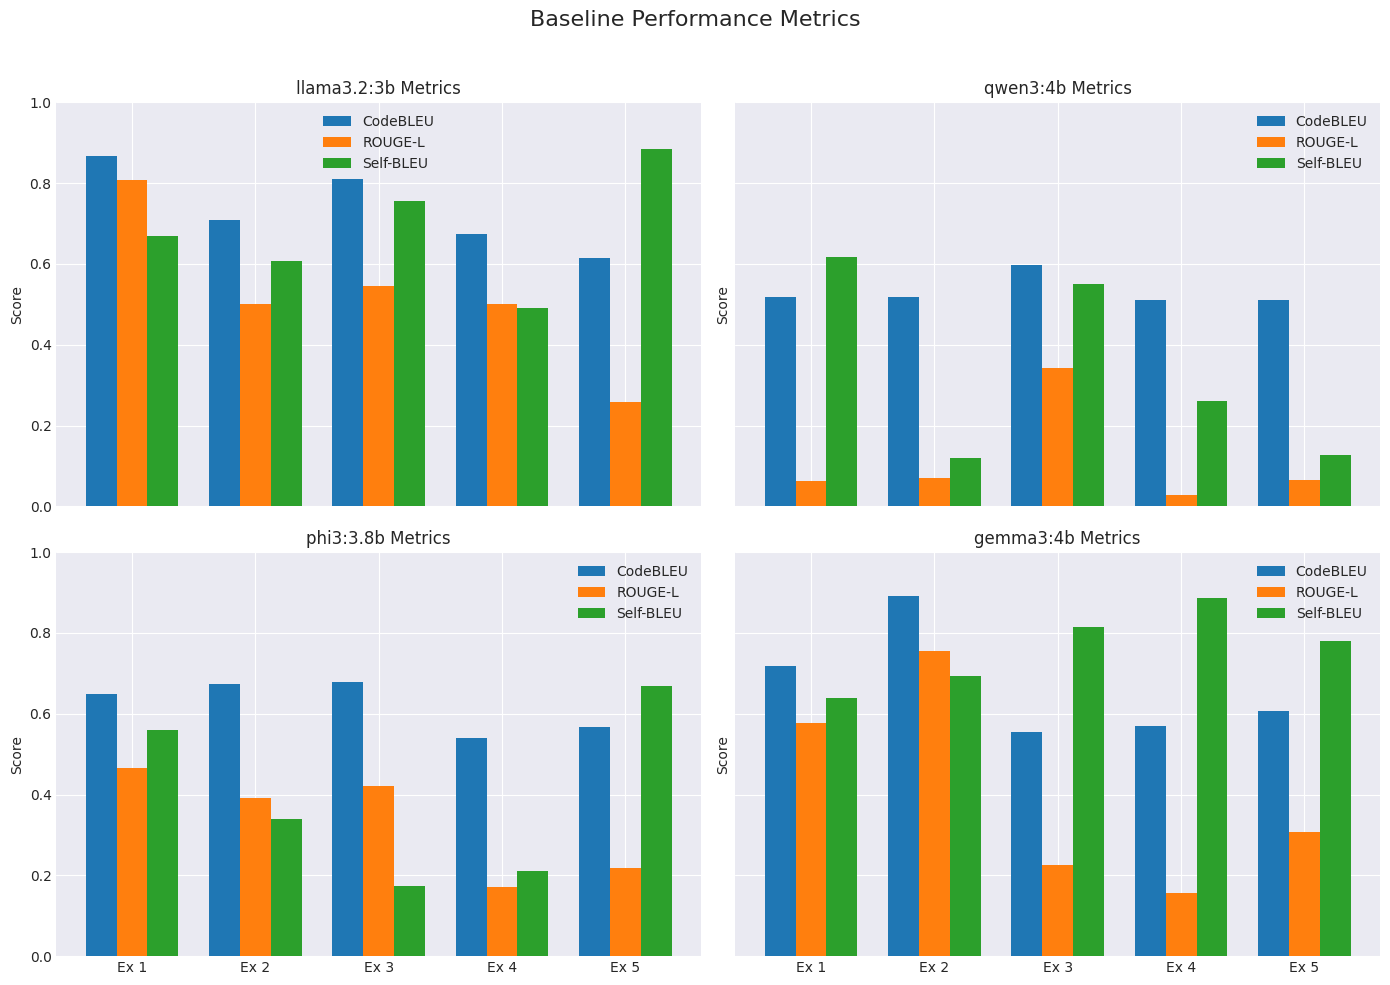

In [89]:
# Plotting the baseline's performance metrics
baseline_extracted_metric_scores = extract_metric_scores(baseline_benchmark_metrics)
plot_model_metrics(baseline_extracted_metric_scores, "Baseline Performance Metrics")

In [90]:
# Plotting the Average Performance Values
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_model_metrics(metric_dict, plot_title="Average Model Benchmark Metrics"):
    metric_names = ["CodeBLEU", "ROUGE-L", "Self-BLEU"]
    model_names = list(metric_dict.keys())
    num_models = len(model_names)

    # Prepare subplot grid size
    nrows = (num_models + 1) // 2 if num_models > 2 else 1
    ncols = 2 if num_models > 1 else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 5 * nrows), squeeze=False)
    
    axes = axes.flatten()

    for i, model_name in enumerate(model_names):
        ax = axes[i]
        triplets = metric_dict[model_name]

        # Compute the mean of each metric across the 5 examples
        codebleu_avg = np.mean([t[0] for t in triplets])
        rouge_avg = np.mean([t[1] for t in triplets])
        selfbleu_avg = np.mean([t[2] for t in triplets])

        averages = [codebleu_avg, rouge_avg, selfbleu_avg]
        x = np.arange(len(metric_names))

        ax.bar(x, averages, width=0.4, color=["skyblue", "lightgreen", "salmon"])
        ax.set_title(f"{model_name} Average Metrics")
        ax.set_xticks(x)
        ax.set_xticklabels(metric_names)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Average Score")

    # Remove unused subplots
    for j in range(len(model_names), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

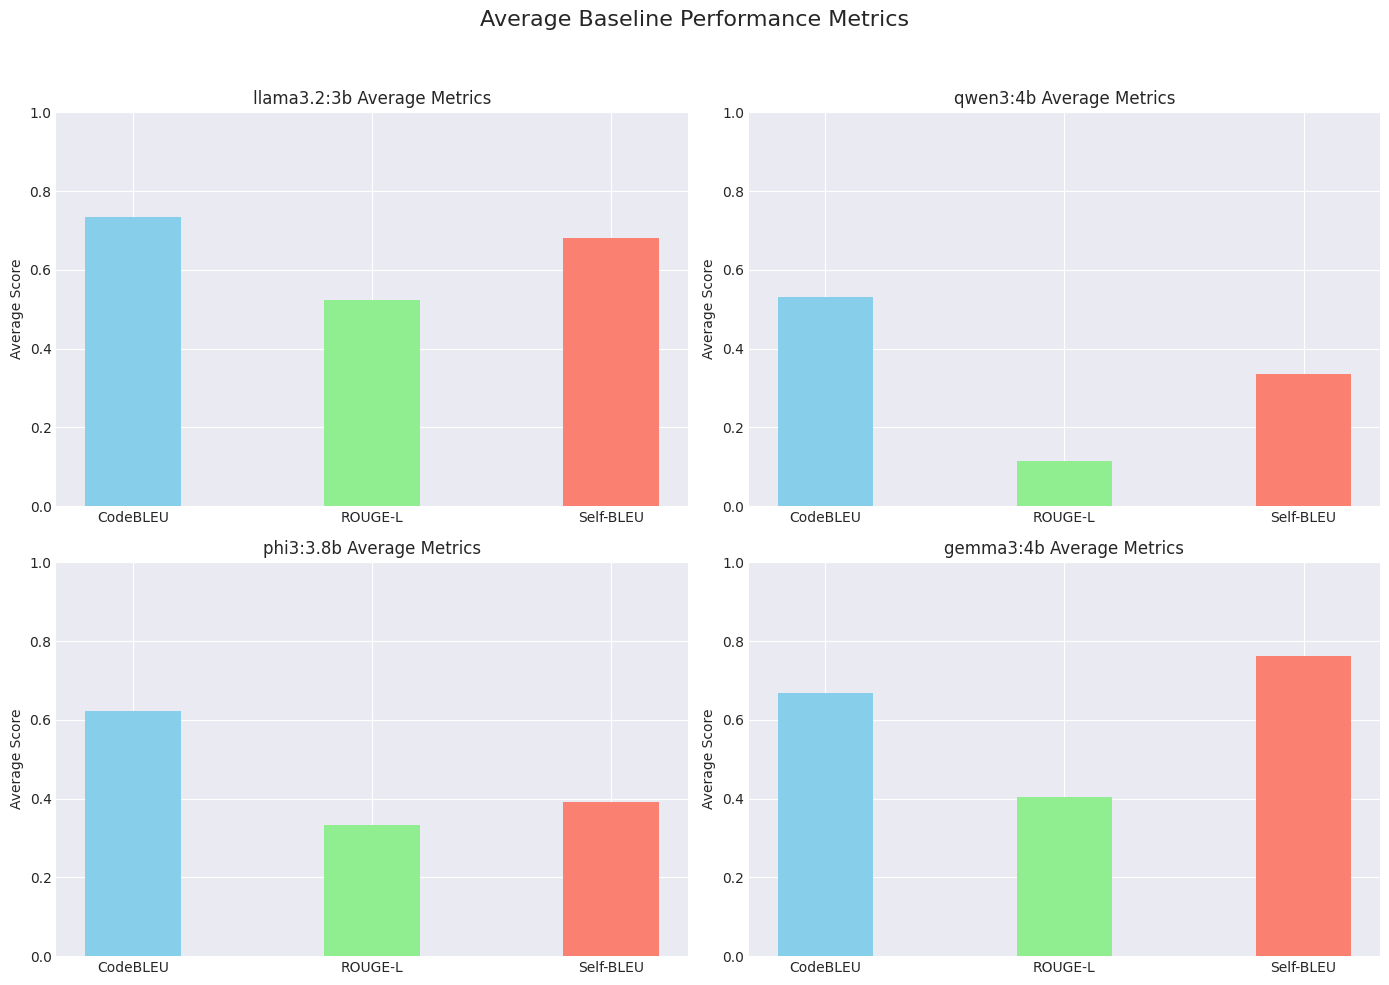

In [91]:
plot_avg_model_metrics(baseline_extracted_metric_scores, "Average Baseline Performance Metrics")

# RAG Grounding Benchmarks

#### Classic RAG

In [160]:
# Classic Vector RAG Retrieval
import numpy as np
from pymilvus import connections, Collection
from transformers import AutoTokenizer, AutoModel
import torch

# --- 1. Connect to Milvus ---
connections.connect("default", host="localhost", port="19530")

# --- 2. Load BAAI/bge-large embedding model and tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-large-en")
_model = AutoModel.from_pretrained("BAAI/bge-large-en")  # Use a private variable to avoid accidental overwrite
_model.eval()

# Move model to device once (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_model.to(device)

def embed_text(text: str) -> np.ndarray:
    """
    Embed text into a normalized vector using BAAI/bge-large model.
    Returns a numpy array normalized for cosine similarity.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = _model(**inputs)  # Use the private _model variable
        # Use pooler_output if available, else mean pooling over tokens
        if hasattr(outputs, "pooler_output"):
            embedding = outputs.pooler_output
        else:
            embedding = outputs.last_hidden_state.mean(dim=1)

        embedding = embedding.cpu().numpy()[0]

    # Normalize embedding vector for cosine similarity
    norm = np.linalg.norm(embedding)
    if norm == 0:
        return embedding
    return embedding / norm

def search_top_k(collection_name: str, query_text: str, top_k: int = 3) -> list:
    """
    Search Milvus collection for the top_k most similar vectors to the query text.
    Uses cosine similarity via inner product metric on normalized embeddings.
    Returns a list of dicts with id, text, and similarity score (higher is better).
    """
    query_vec = embed_text(query_text)

    collection = Collection(collection_name)
    collection.load()

    search_params = {
        "metric_type": "IP",  # Inner Product metric works as cosine similarity on normalized vectors
        "params": {"nprobe": 10}
    }

    results = collection.search(
        data=[query_vec],
        anns_field="embedding",
        param=search_params,
        limit=top_k,
        output_fields=["id", "text"]
    )

    hits = results[0]
    top_results = []
    for hit in hits:
        top_results.append({
            "id": hit.entity.get("id"),
            "text": hit.entity.get("text"),
            "score": hit.distance  # For IP, higher score = more similar
        })

    return top_results

In [196]:
# Graph RAG Retrieval
from neo4j import GraphDatabase
import spacy

# --- Configuration ---
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

# --- Initialize Neo4j driver and spaCy model once ---
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
nlp = spacy.load("en_core_web_lg")


def retrieve_relevant_problems(question: str, top_k: int = 3):
    """Retrieve top-k relevant LeetCode problems for a given question."""
    
    def extract_keywords(text):
        doc = nlp(text)
        return list({token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "VERB"] and not token.is_stop})
    
    def extract_concepts(text):
        doc = nlp(text)
        return list({ent.text for ent in doc.ents if ent.label_ in ["ORG", "PRODUCT", "WORK_OF_ART", "LANGUAGE", "EVENT"]})
    
    def ensure_index(session):
        check_query = """
        SHOW INDEXES YIELD name 
        WHERE name = 'problemFullTextIndex' 
        RETURN count(*) AS exists
        """
        if session.run(check_query).single()["exists"] == 0:
            session.run("""
            CREATE FULLTEXT INDEX problemFullTextIndex
            FOR (n:Problem)
            ON EACH [n.content]
            """)
    
    def query(session, keywords, concepts):
        query_string = " ".join(keywords)
        fulltext_query = """
        CALL db.index.fulltext.queryNodes('problemFullTextIndex', $search_string) YIELD node, score
        OPTIONAL MATCH (node)-[:MENTIONS]->(c:Concept)
        RETURN node.id AS problem_id, node.content AS content, collect(DISTINCT c.name) AS concepts, score
        ORDER BY score DESC
        LIMIT $top_k
        """
        concept_query = """
        MATCH (c:Concept)<-[:MENTIONS]-(p:Problem)
        WHERE c.name IN $concepts
        RETURN p.id AS problem_id, p.content AS content, collect(DISTINCT c.name) AS concepts, 0.5 AS score
        LIMIT $top_k
        """
        
        fulltext_results = session.run(fulltext_query, search_string=query_string, top_k=top_k).data()
        concept_results = session.run(concept_query, concepts=concepts, top_k=top_k).data()
        
        combined = {r['problem_id']: r for r in fulltext_results}
        for r in concept_results:
            if r['problem_id'] not in combined:
                combined[r['problem_id']] = r
            else:
                combined[r['problem_id']]['concepts'] = list(set(combined[r['problem_id']]['concepts'] + r['concepts']))
                combined[r['problem_id']]['score'] += 0.25
        
        sorted_combined = sorted(combined.values(), key=lambda x: x['score'], reverse=True)
        return sorted_combined[:top_k]
    
    with driver.session() as session:
        ensure_index(session)
        keywords = extract_keywords(question)
        concepts = extract_concepts(question)
        return query(session, keywords, concepts)

def retrieve_relevant_python_docs(user_query: str, top_k: int = 3):
    """Retrieve top-k relevant PythonDocSections from Neo4j for a given user query."""

    def extract_keywords(text):
        doc = nlp(text)
        return list({token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "PROPN"] and not token.is_stop})

    keywords = extract_keywords(user_query)
    if not keywords:
        print("[retrieve] No keywords extracted from query.")
        return []

    # Build dynamic OR conditions using parameterized keywords
    conditions = [f"toLower(s.content) CONTAINS toLower($kw{i})" for i in range(len(keywords))]
    cypher_conditions = " OR ".join(conditions)

    # Build parameter map
    param_map = {f"kw{i}": kw for i, kw in enumerate(keywords)}
    param_map["top_k"] = top_k
    param_map["keywords"] = keywords  # For keyword_hits computation

    query = f"""
    MATCH (s:PythonDocSection)
    WHERE {cypher_conditions}
    OPTIONAL MATCH (s)-[:MENTIONS]->(c:Concept)
    RETURN s.id AS doc_id,
           s.content AS content,
           collect(DISTINCT c.name) AS concepts,
           size([kw IN $keywords WHERE toLower(s.content) CONTAINS kw]) AS keyword_hits
    ORDER BY keyword_hits DESC
    LIMIT $top_k
    """

    with driver.session() as session:
        result = session.run(query, parameters=param_map)
        return result.data()

In [197]:
def string_search_top_k(collection_name: str, query: str) -> str:
    results = search_top_k(collection_name, query, top_k=3)
    chunk_string = ""
    for r in results:
        chunk_string += r["text"]

    return chunk_string

In [198]:
def string_retrieve_relevant_problems(query: str) -> str:
    problems = retrieve_relevant_problems(query)
    chunk_string = ""
    for match in problems:
        chunk_string += match["content"]

    return chunk_string

def string_retrieve_relevant_python_docs(query: str) -> str:
    problems = retrieve_relevant_python_docs(query)
    chunk_string = ""
    for match in problems:
        chunk_string += match["content"]

    return chunk_string

In [176]:
# Running Benchmark for Classic RAG (leet code dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_search_top_k("leetcode_kb", content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2="", ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [03:02<09:08, 182.85s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 2/4 [17:14<19:13, 576.54s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [20:15<06:35, 395.54s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [22:43<00:00, 340.78s/it]


In [177]:
# Store the Results of the Baseline Benchmark
import json

with open('leetcode_classicrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

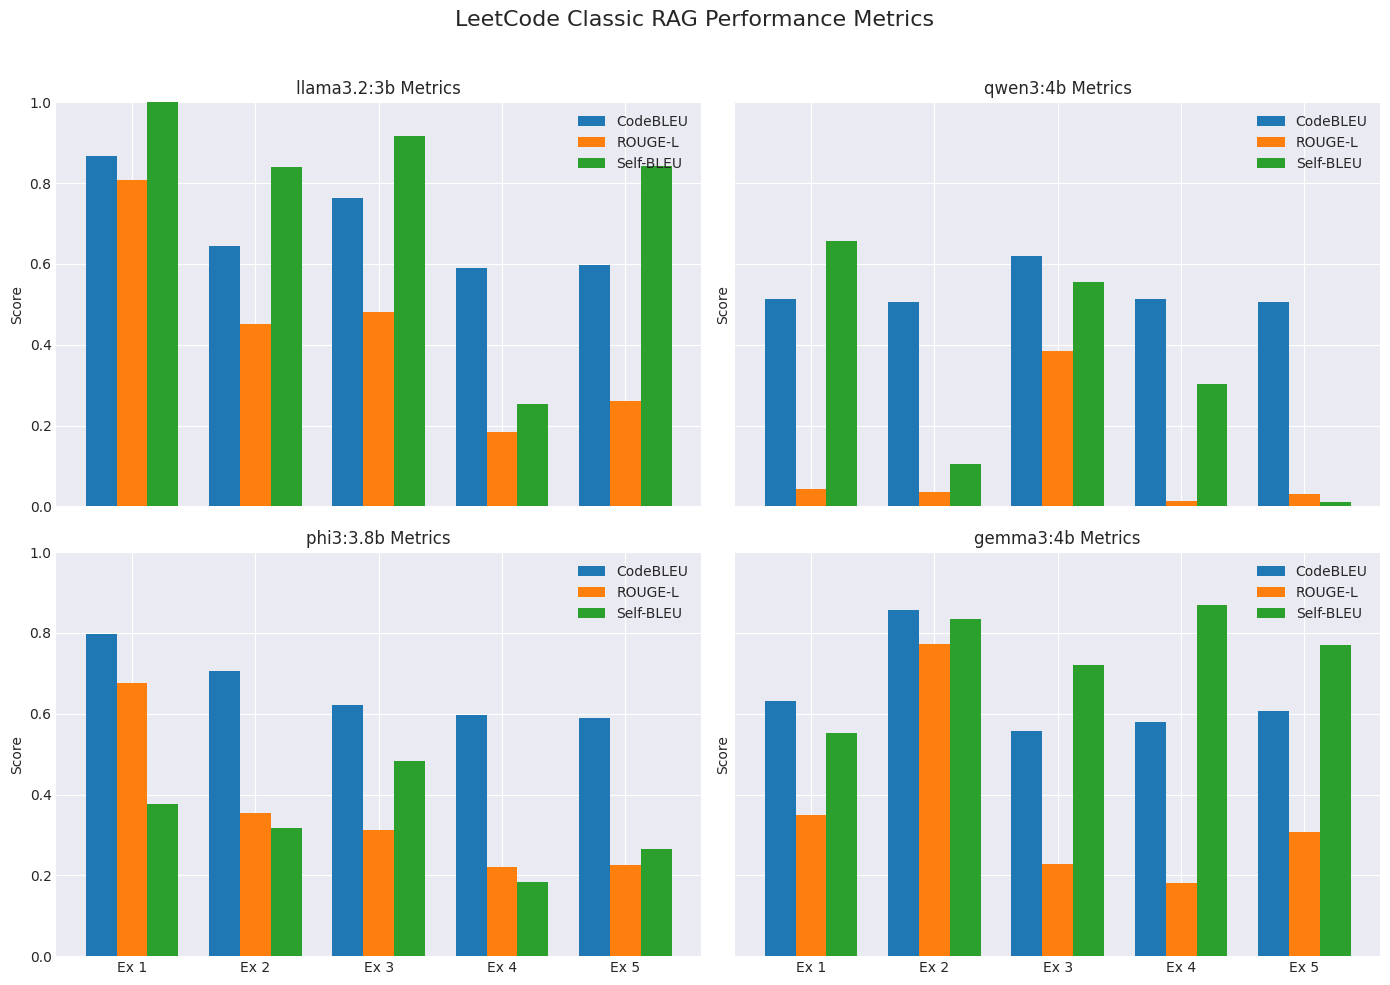

In [178]:
# Plotting the classic RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode Classic RAG Performance Metrics")

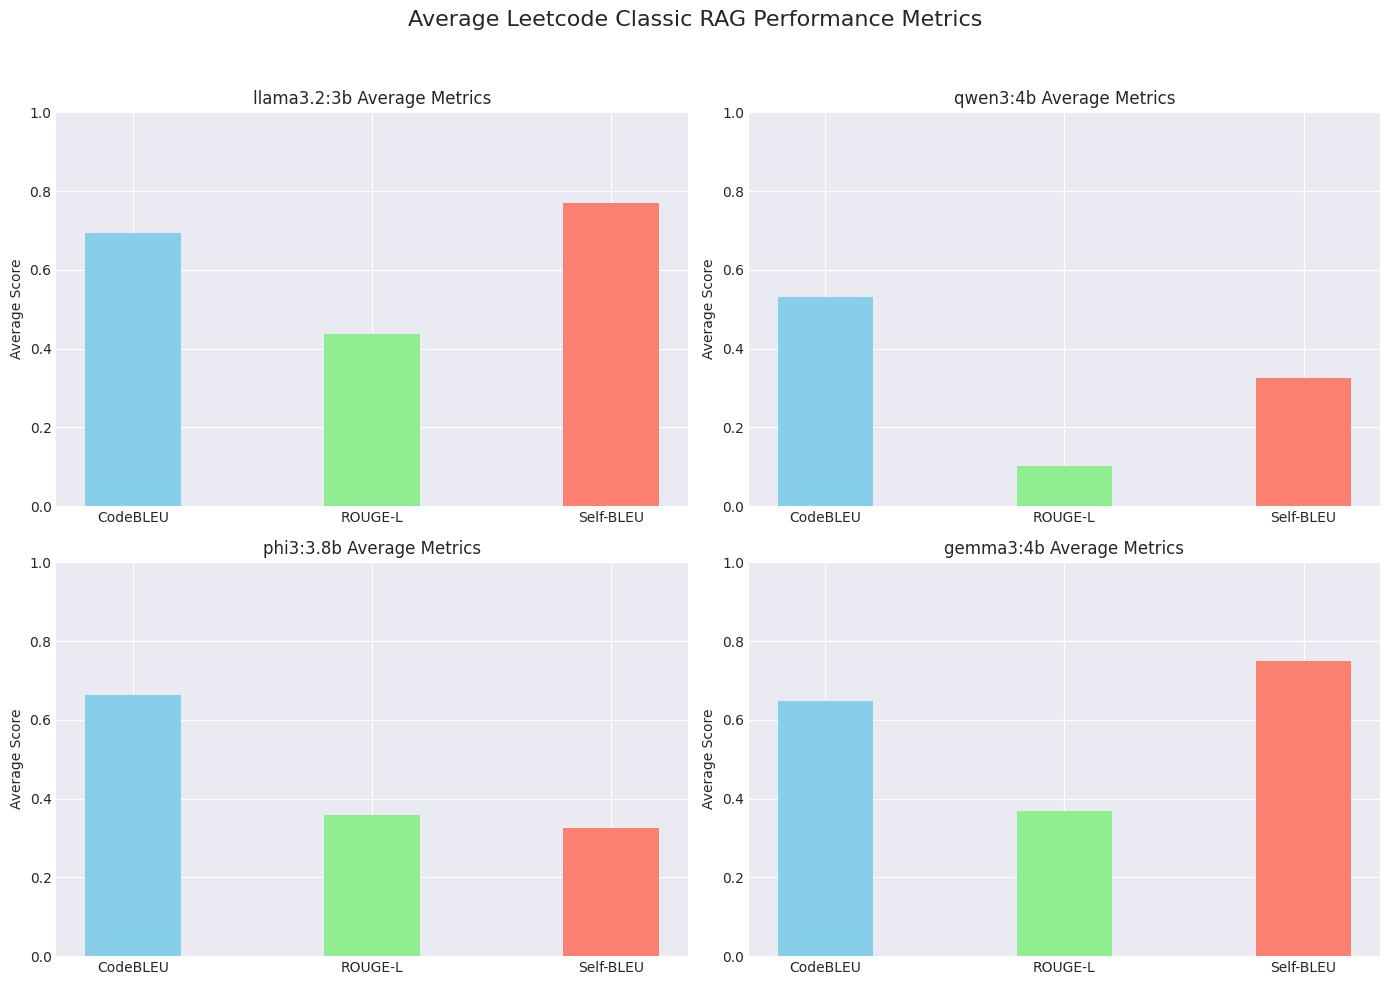

In [179]:
plot_avg_model_metrics(extracted_metric_scores, "Average Leetcode Classic RAG Performance Metrics")

In [180]:
# Running Benchmark for Classic RAG (Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_2 = string_search_top_k("pydocs_kb", content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1="", rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [02:41<08:03, 161.09s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 2/4 [40:38<46:51, 1405.73s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [43:49<14:11, 851.40s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [46:11<00:00, 692.97s/it]


In [181]:
# Store the Results of the Baseline Benchmark
import json

with open('pydocs_classicrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

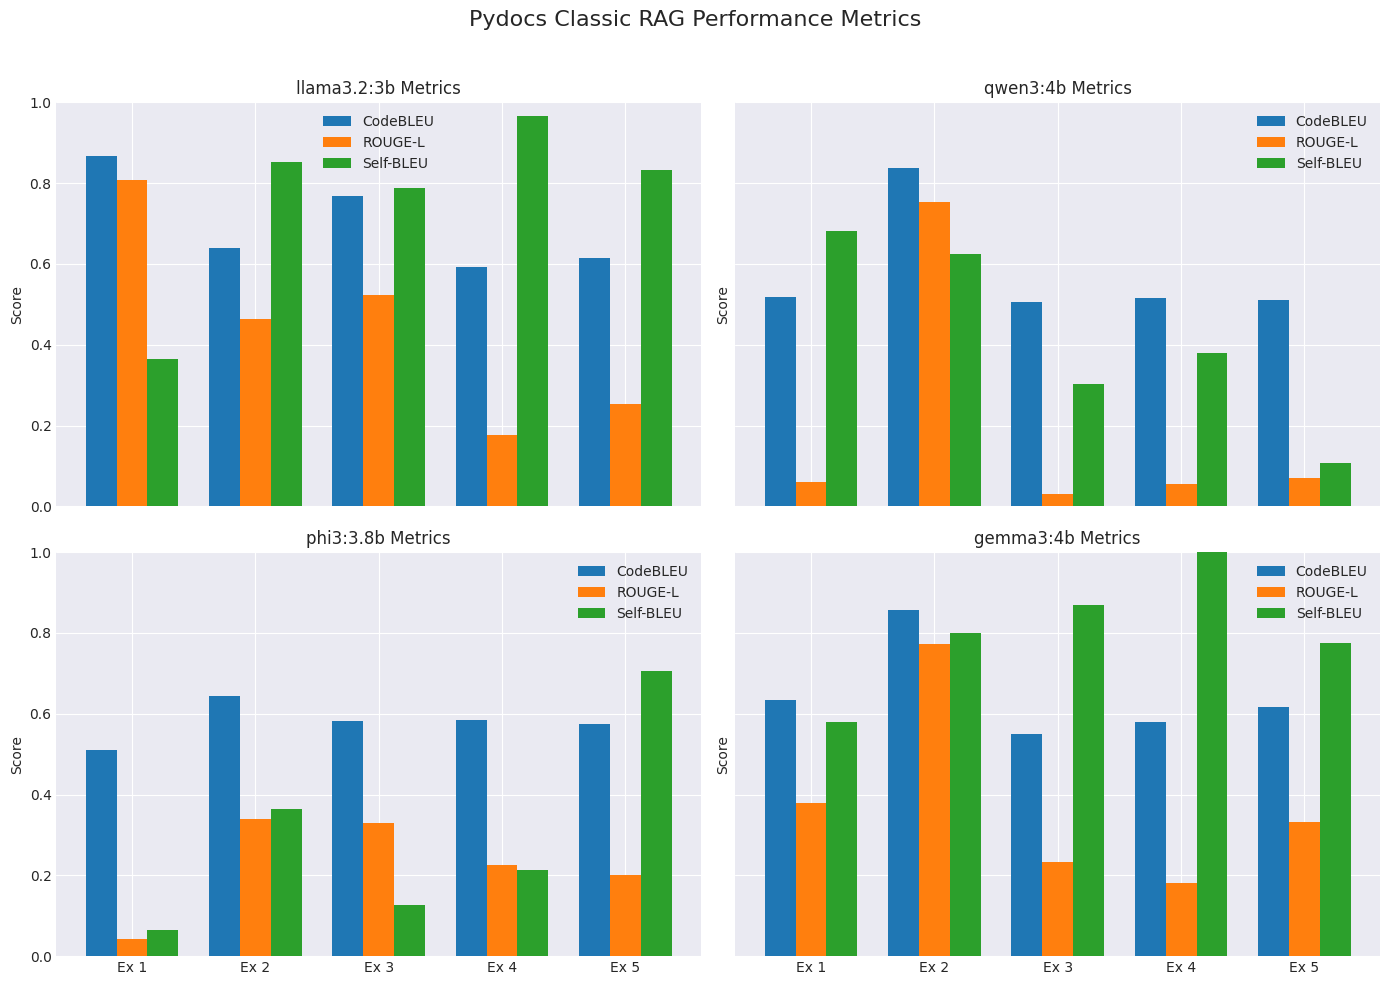

In [182]:
# Plotting the classic RAG pydocs-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "Pydocs Classic RAG Performance Metrics")

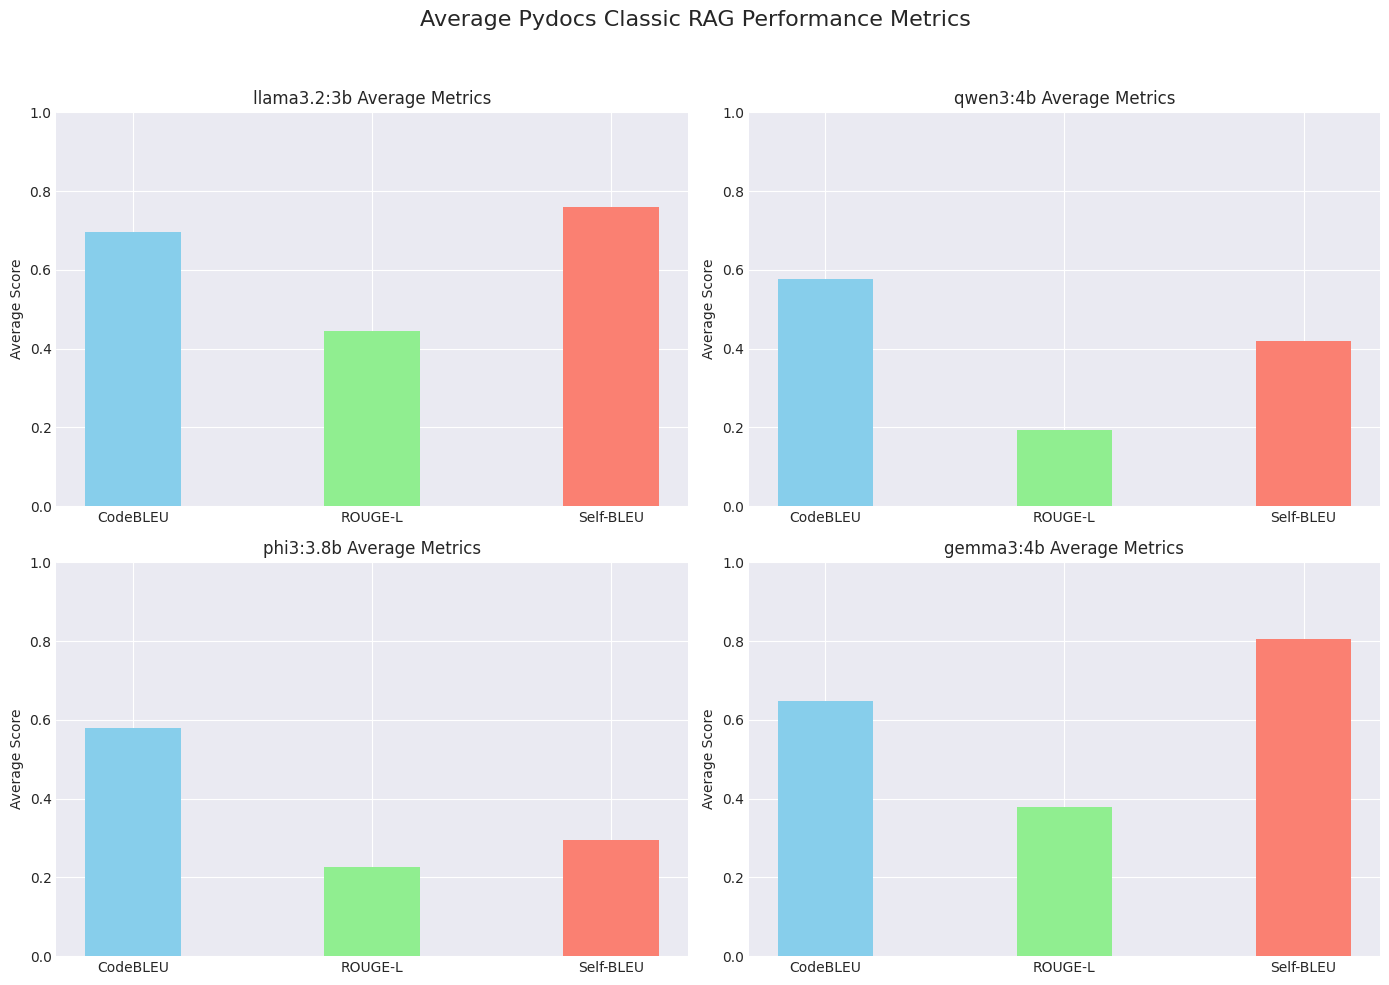

In [183]:
plot_avg_model_metrics(extracted_metric_scores, "Average Pydocs Classic RAG Performance Metrics")

In [184]:
# Running Benchmark for Classic RAG (Leetcode AND Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_search_top_k("leetcode_kb", content_value)
        rag_2 = string_search_top_k("pydocs_kb", content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [02:47<08:22, 167.62s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 2/4 [15:06<16:47, 503.88s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [18:06<05:55, 355.80s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [20:24<00:00, 306.06s/it]


In [185]:
# Store the Results of the Baseline Benchmark
import json

with open('pydocs_and_leetcode_classicrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

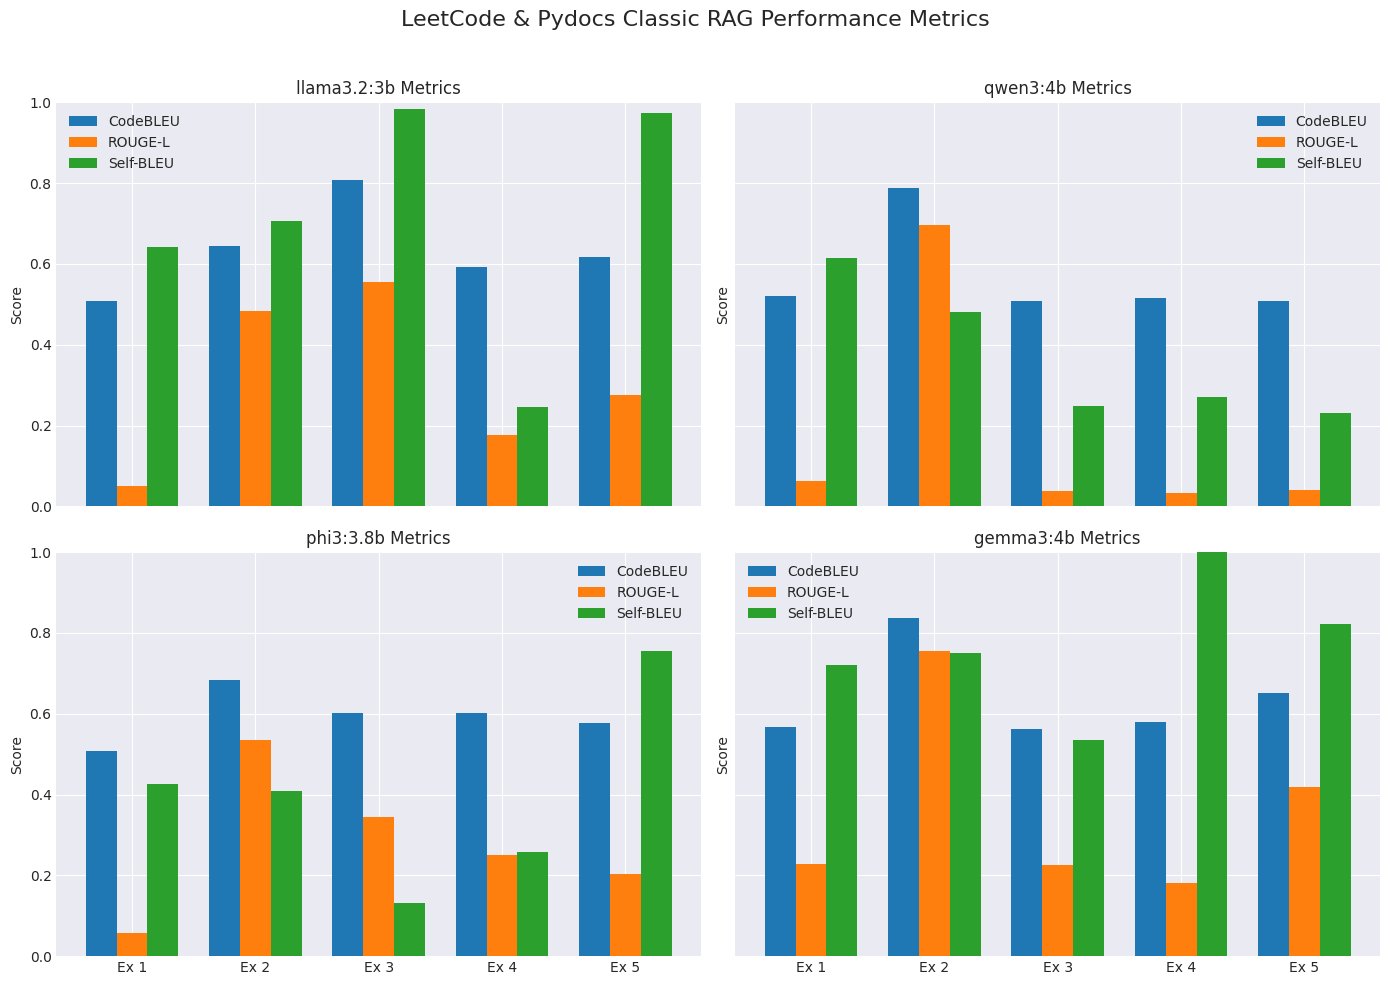

In [186]:
# Plotting the classic RAG pydocs-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode & Pydocs Classic RAG Performance Metrics")

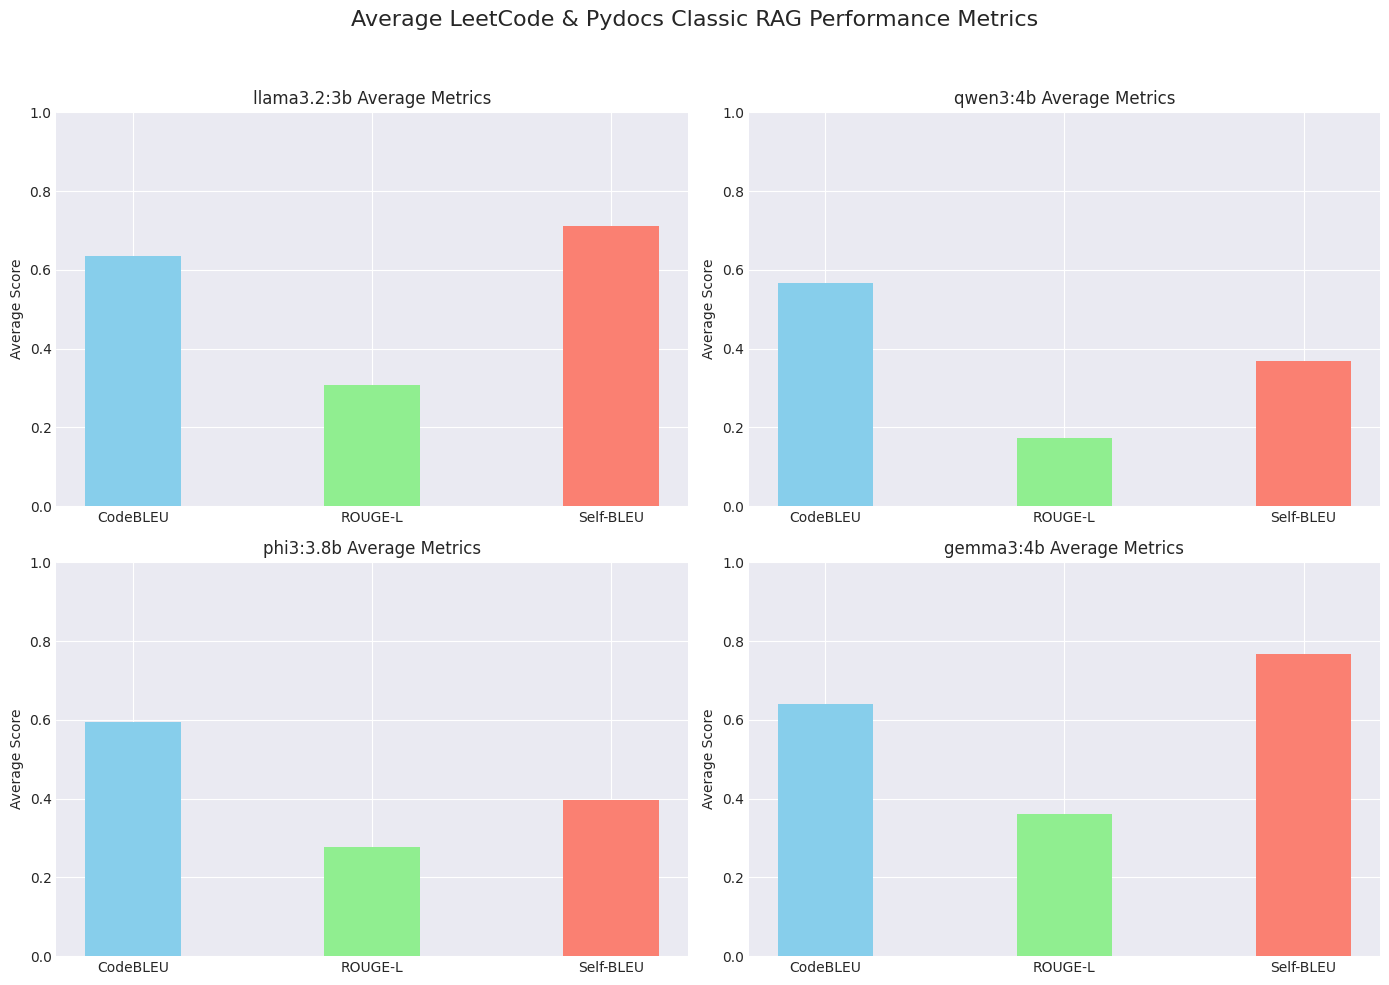

In [187]:
plot_avg_model_metrics(extracted_metric_scores, "Average LeetCode & Pydocs Classic RAG Performance Metrics")

In [188]:
# Running Benchmark for Graph RAG (Leetcode dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_retrieve_relevant_problems(content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2="", ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [02:49<08:28, 169.43s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 2/4 [44:05<50:52, 1526.29s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [47:15<15:16, 916.18s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [49:37<00:00, 744.50s/it]


In [189]:
# Store the Results of the Baseline Benchmark
import json

with open('leetcode_graphrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

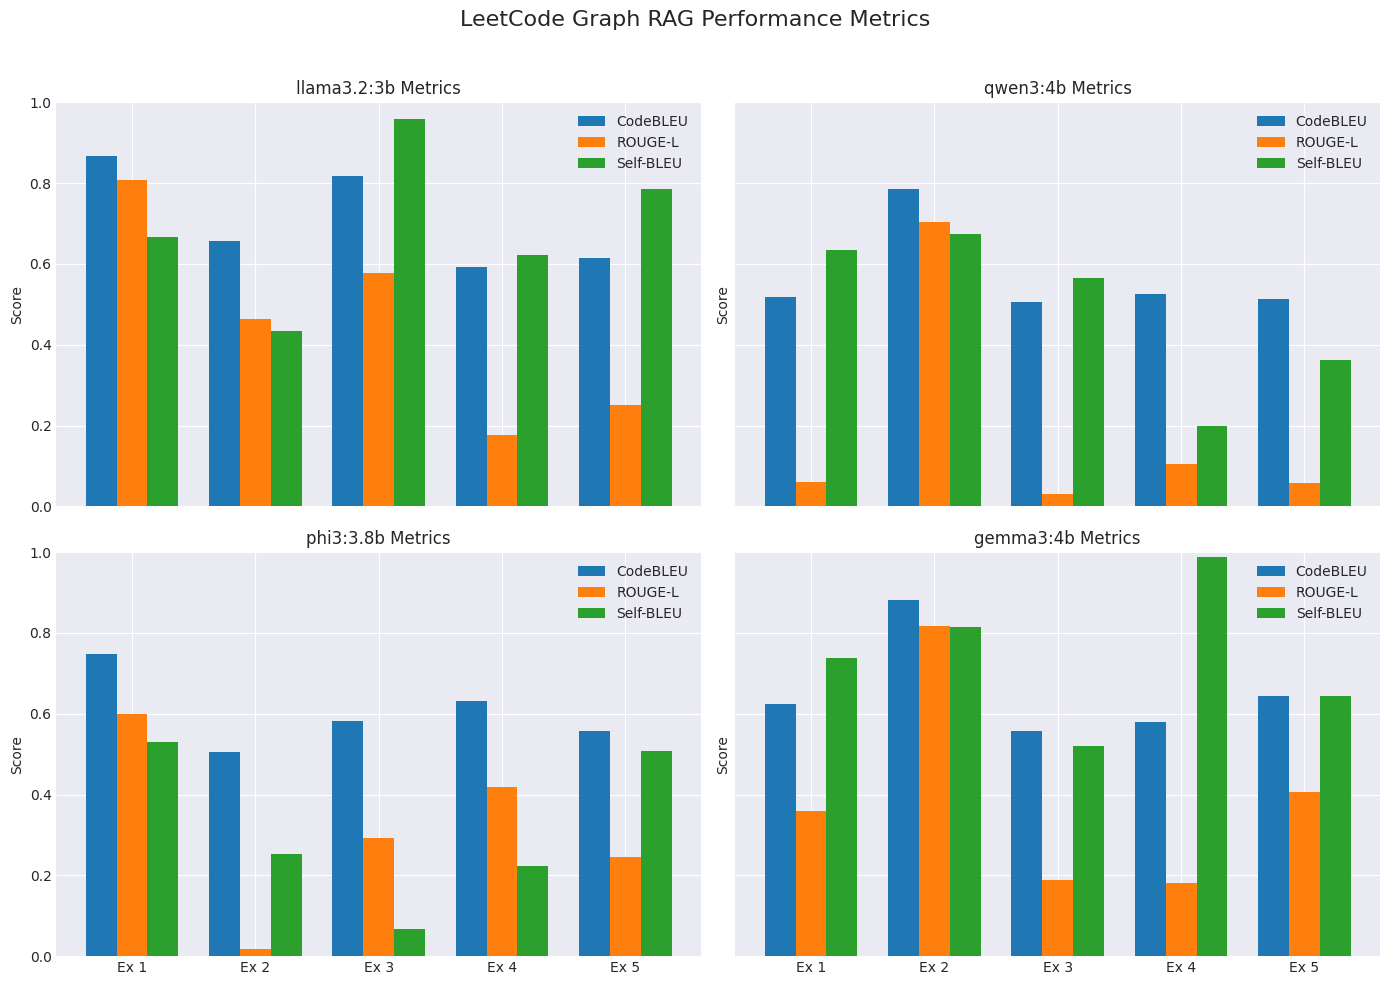

In [190]:
# Plotting the Graph RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode Graph RAG Performance Metrics")

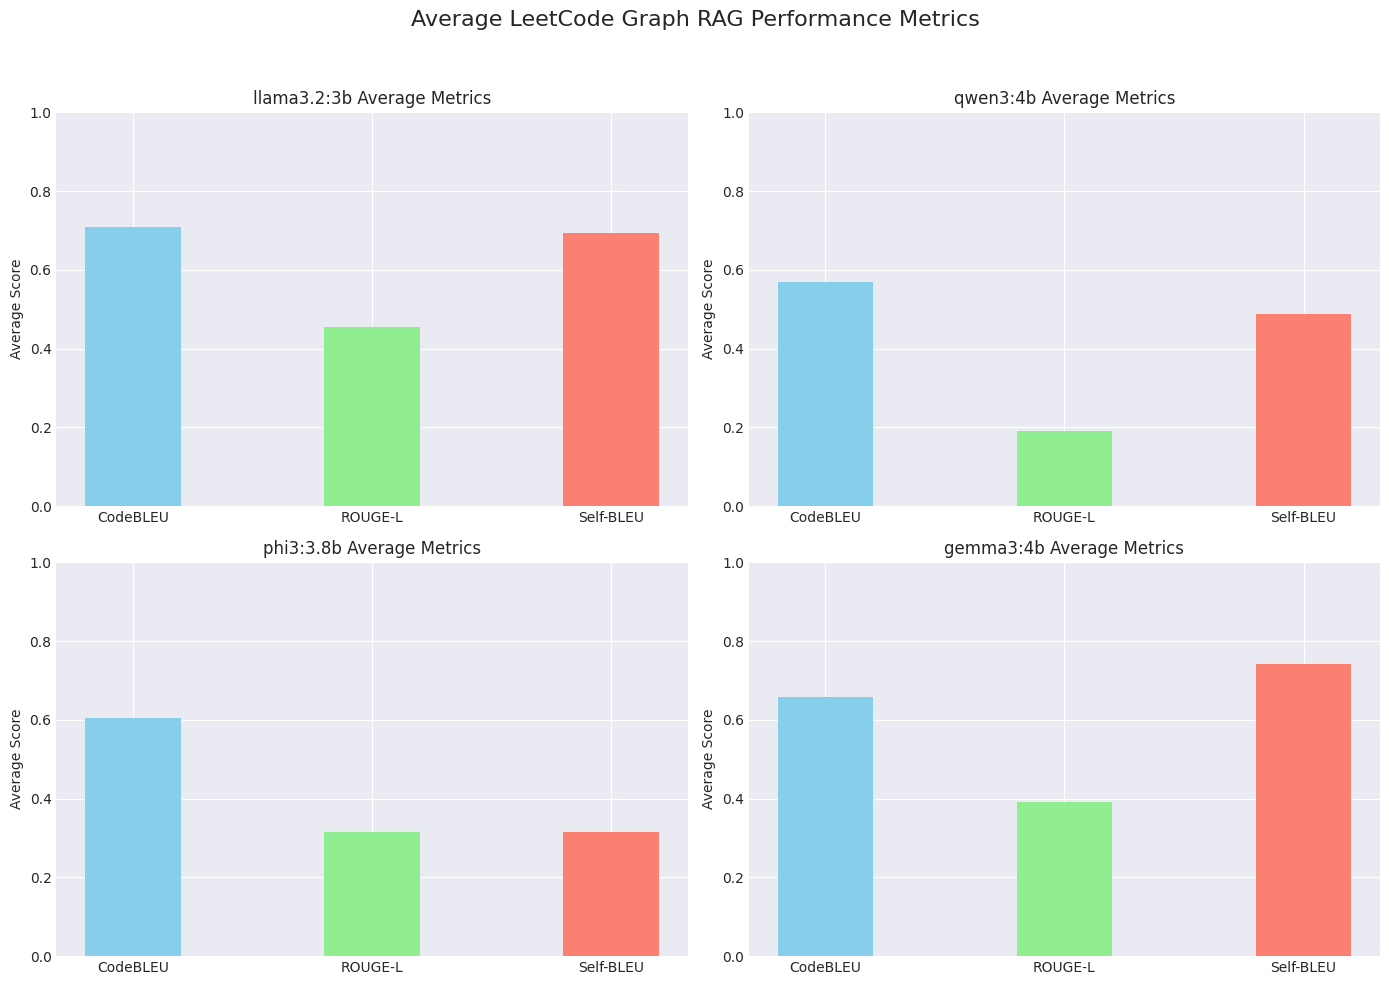

In [191]:
plot_avg_model_metrics(extracted_metric_scores, "Average LeetCode Graph RAG Performance Metrics")

In [199]:
# Running Benchmark for Graph RAG (Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_2 = string_retrieve_relevant_python_docs(content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1="", rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████████▌                                                                                                                   | 1/4 [02:45<08:17, 165.79s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 2/4 [17:50<20:00, 600.39s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3/4 [21:04<06:54, 414.74s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [23:31<00:00, 352.92s/it]


In [200]:
# Store the Results of the Baseline Benchmark
import json

with open('pydocs_graphrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

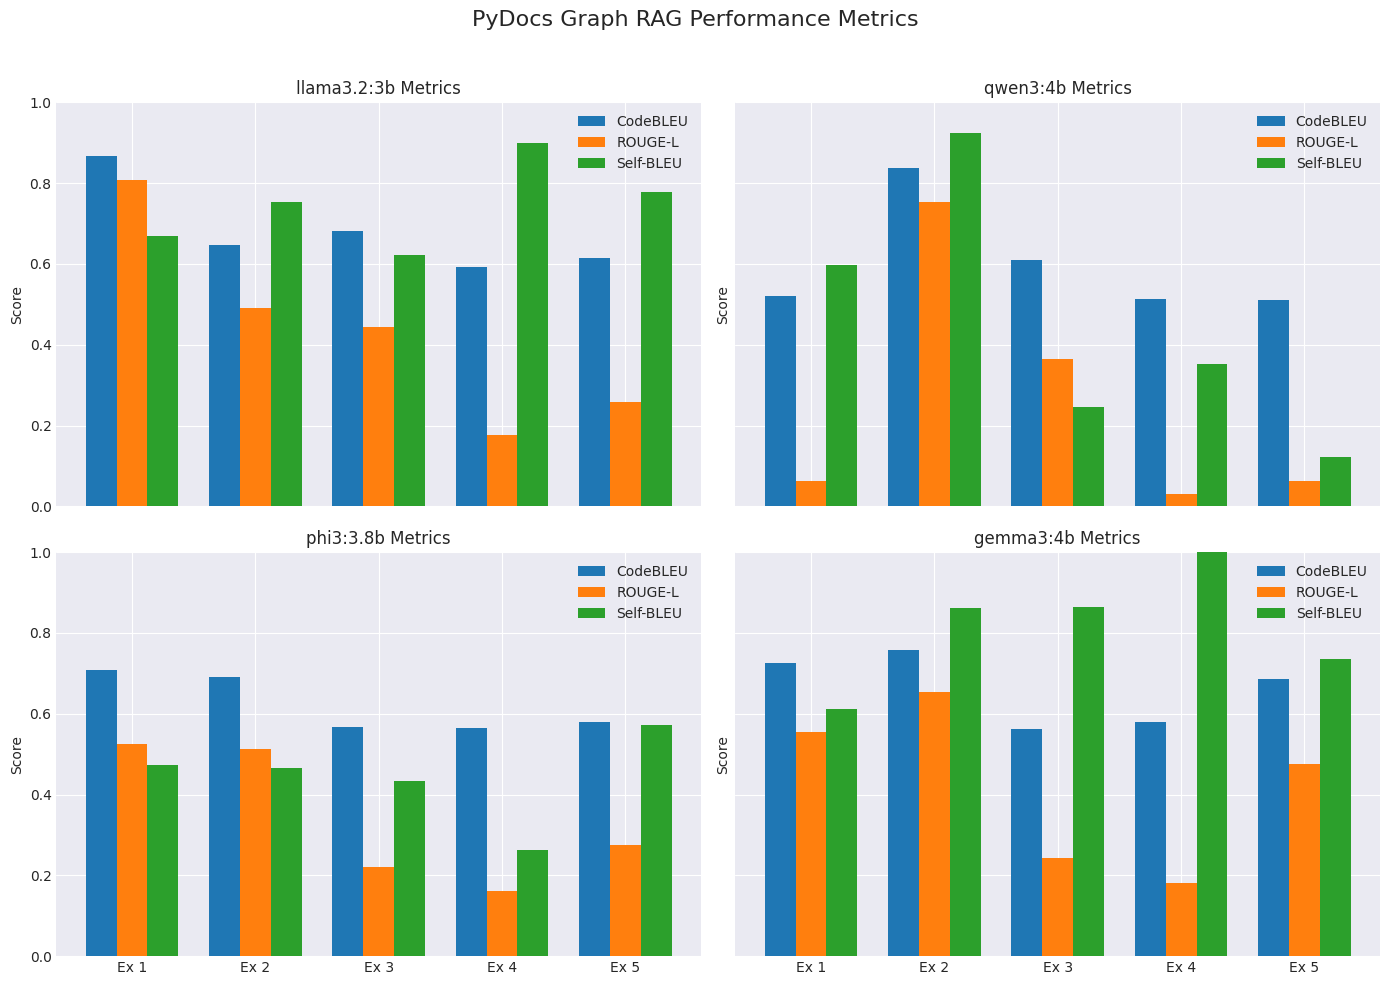

In [201]:
# Plotting the Graph RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "PyDocs Graph RAG Performance Metrics")

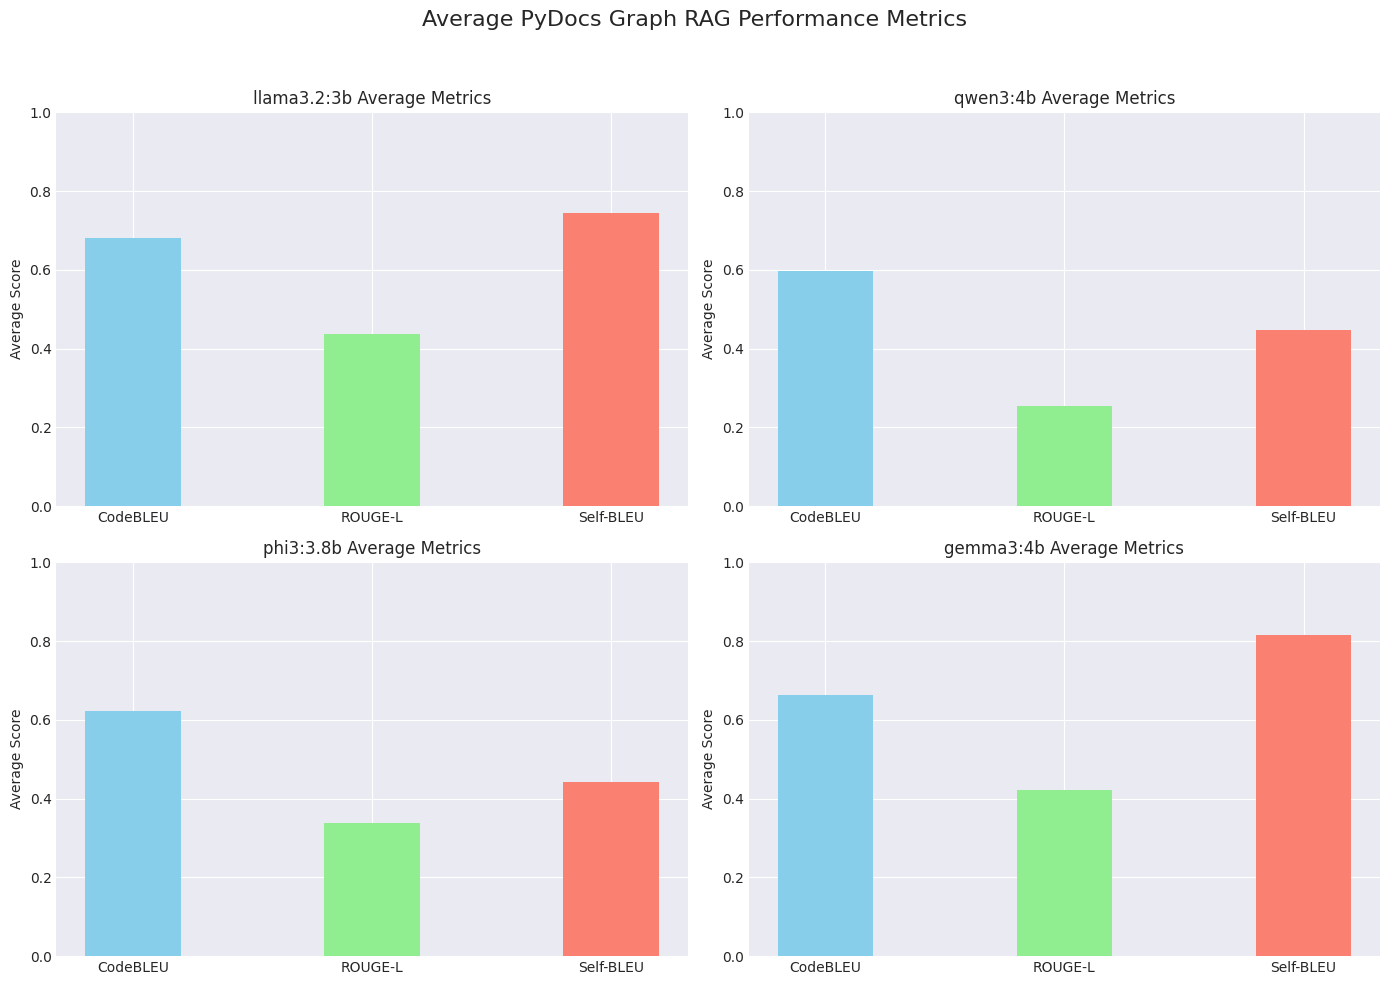

In [202]:
plot_avg_model_metrics(extracted_metric_scores, "Average PyDocs Graph RAG Performance Metrics")

In [203]:
# Running Benchmark for Graph RAG (LeetCode + Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_retrieve_relevant_problems(content_value)
        rag_2 = string_retrieve_relevant_python_docs(content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████▊                                                                                                        | 1/4 [03:10<09:30, 190.07s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 2/4 [19:53<22:17, 668.59s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3/4 [23:03<07:29, 449.94s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [25:30<00:00, 382.72s/it]


In [204]:
# Store the Results of the Baseline Benchmark
import json

with open('leetcode_and_pydocs_graphrag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

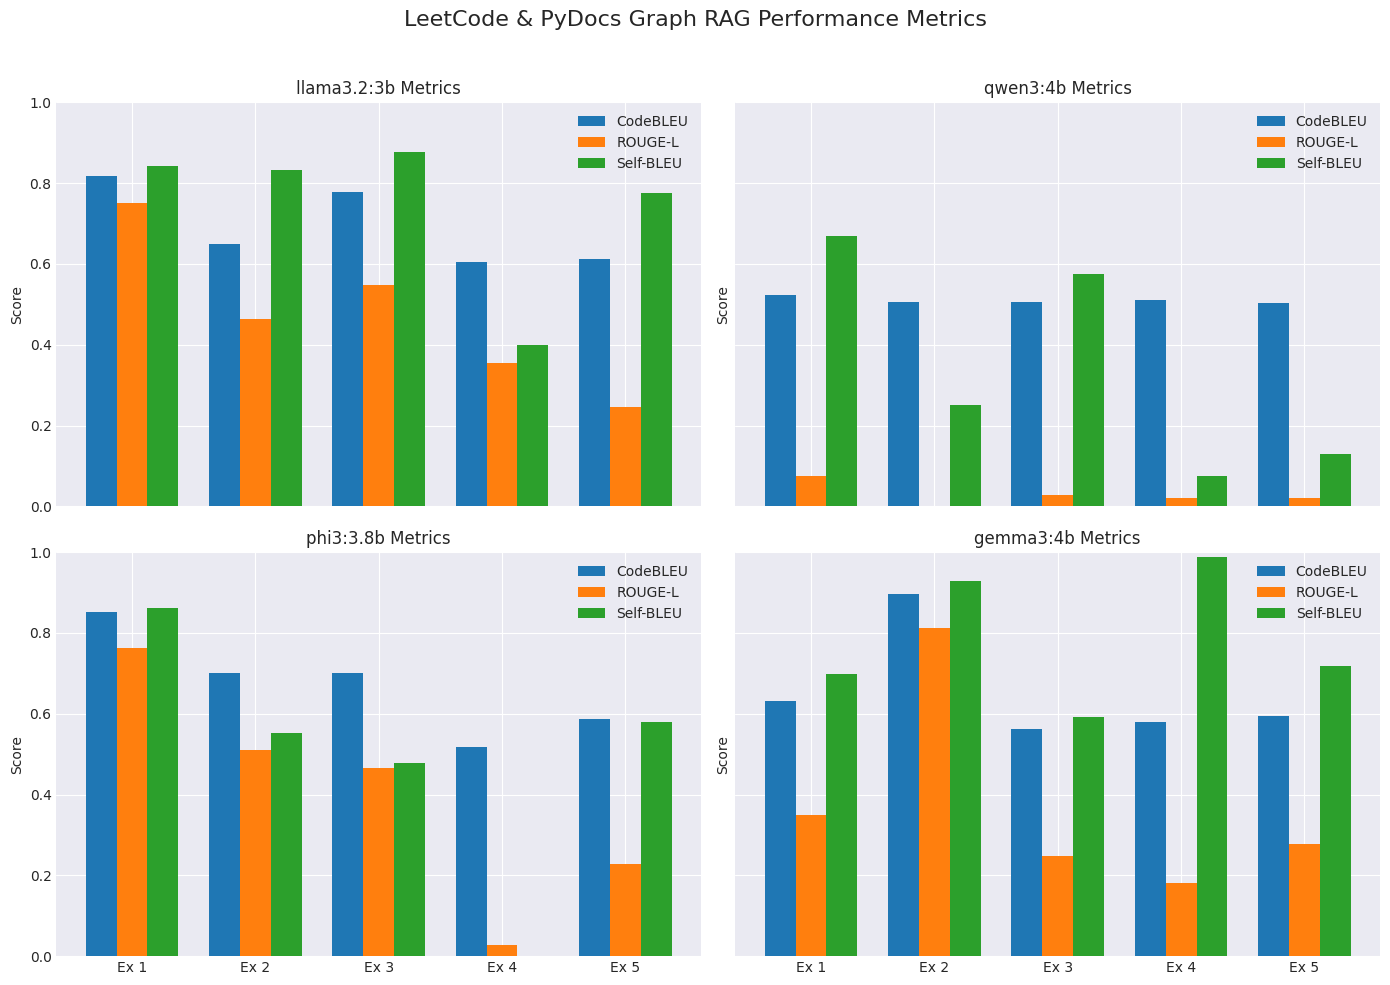

In [205]:
# Plotting the Graph RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode & PyDocs Graph RAG Performance Metrics")

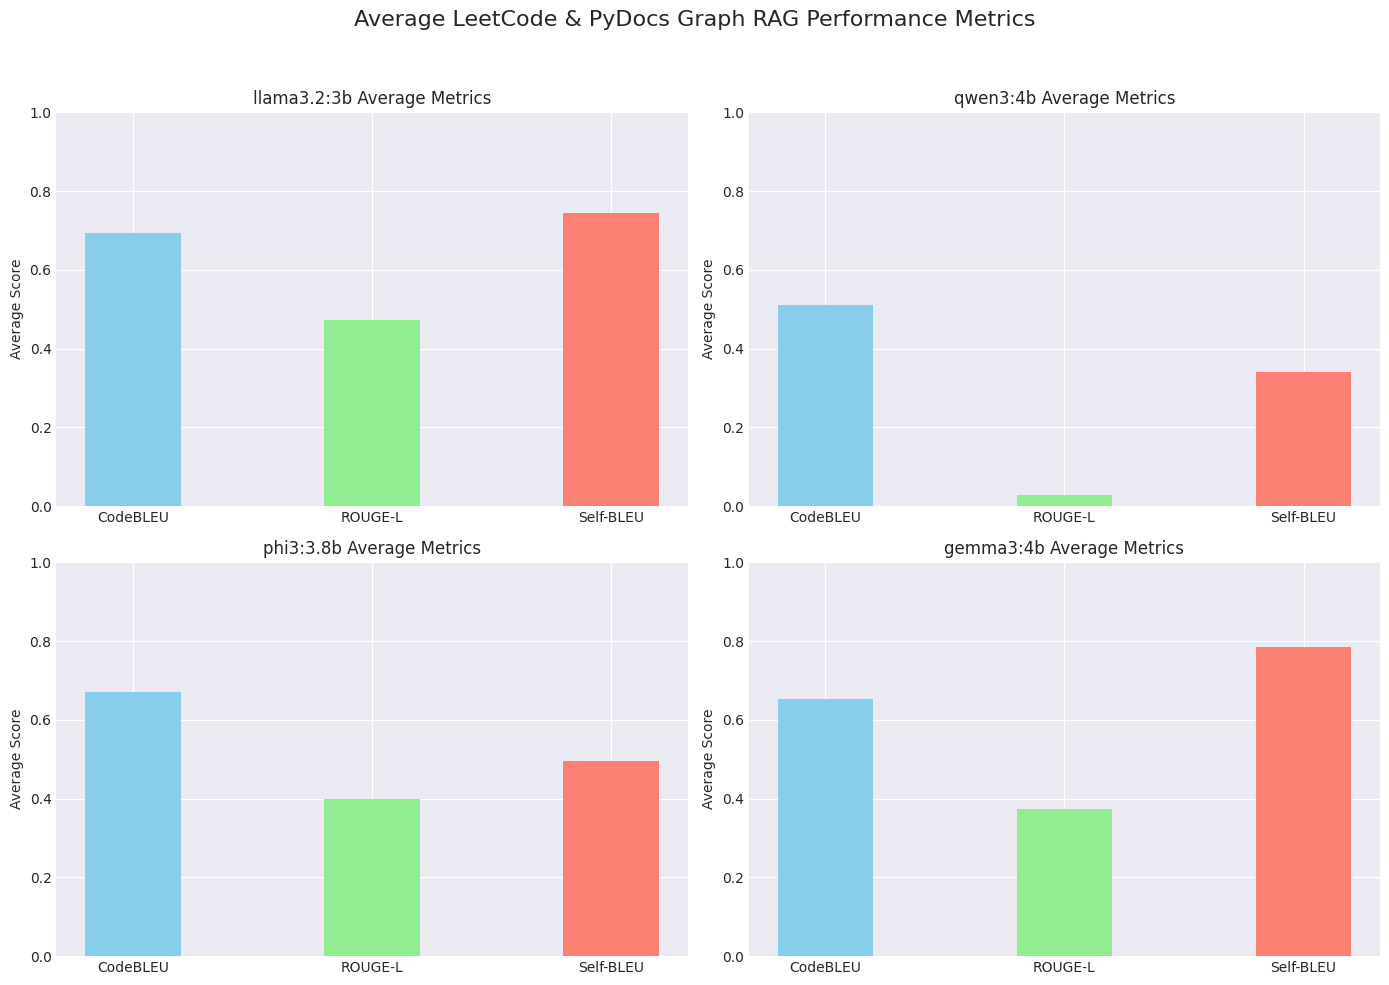

In [206]:
plot_avg_model_metrics(extracted_metric_scores, "Average LeetCode & PyDocs Graph RAG Performance Metrics")

In [207]:
# Running Benchmark for Classic + Graph RAG (LeetCode + Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_search_top_k("leetcode_kb", content_value)
        rag_2 = string_retrieve_relevant_python_docs(content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████▊                                                                                                        | 1/4 [02:48<08:26, 168.82s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 2/4 [31:20<35:52, 1076.49s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3/4 [34:31<11:12, 672.18s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [36:57<00:00, 554.31s/it]


In [208]:
# Store the Results of the Baseline Benchmark
import json

with open('leetcode_and_pydocs_classic_graph_rag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

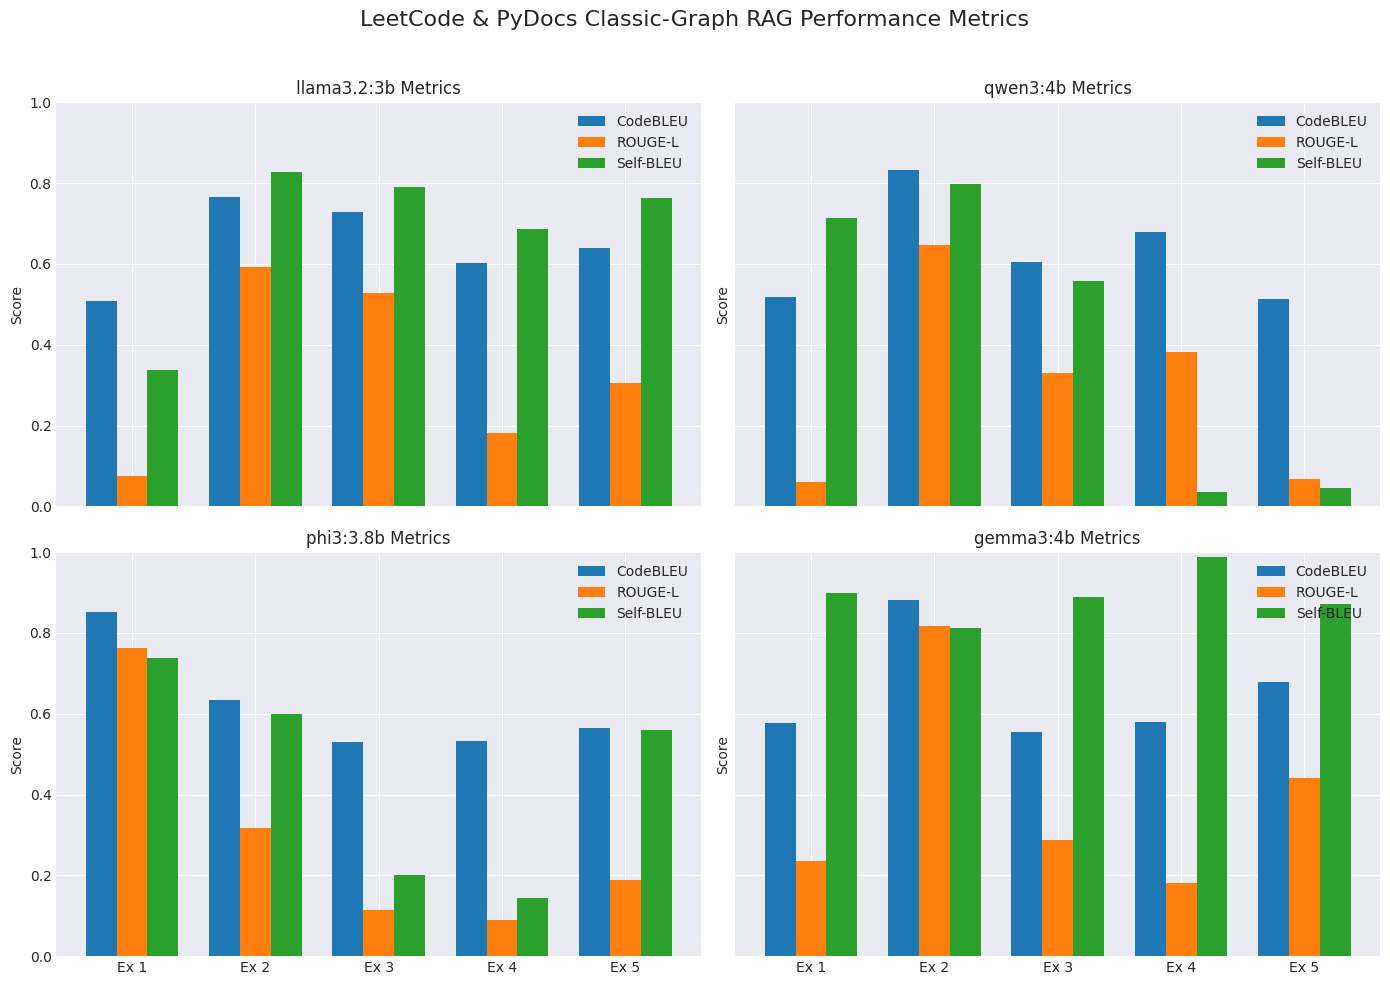

In [209]:
# Plotting the Graph RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode & PyDocs Classic-Graph RAG Performance Metrics")

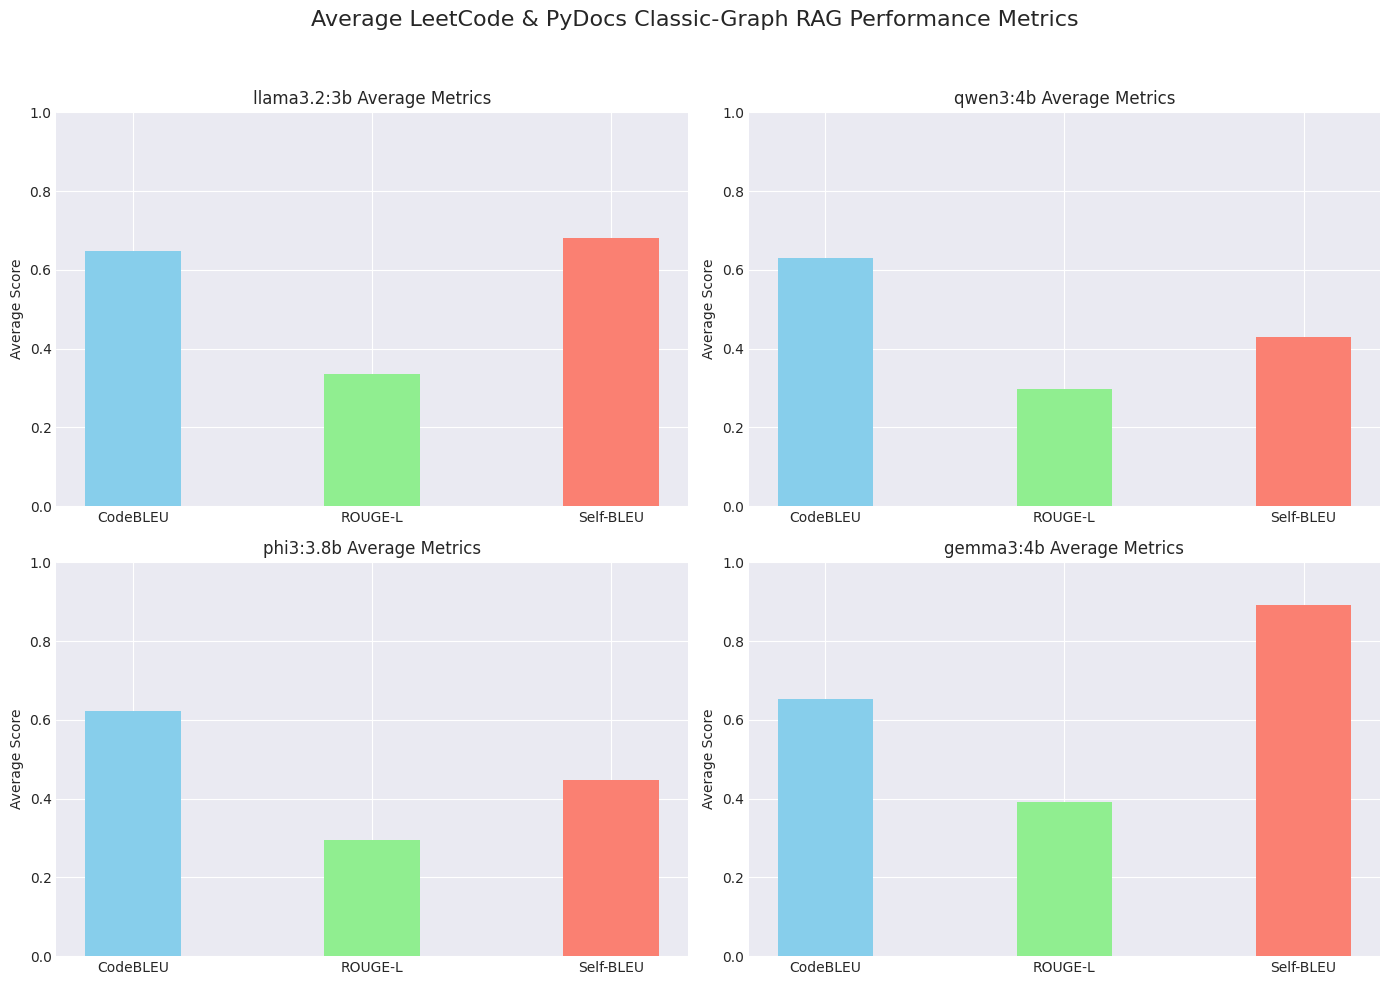

In [210]:
plot_avg_model_metrics(extracted_metric_scores, "Average LeetCode & PyDocs Classic-Graph RAG Performance Metrics")

In [211]:
# Running Benchmark for Graph + Classic RAG (LeetCode + Pydocs dataset)
from tqdm import tqdm

benchmark_metrics = {}


benchmark_metrics["llama3.2:3b"] = []
benchmark_metrics["qwen3:4b"] = []
benchmark_metrics["phi3:3.8b"] = []
benchmark_metrics["gemma3:4b"] = []

for model in tqdm(model_list, desc="Models"):
    for index, row in cleaned_dataset.iloc[:5].iterrows():
        content_value = row['content']
        python_value = row['python']

        rag_1 = string_retrieve_relevant_problems(content_value)
        rag_2 = string_search_top_k("pydocs_kb", content_value)
        
        metrics = run_benchmark(system_prompt, content_value, model, user_prompt_template, rag_1=rag_1, rag_2=rag_2, ground_truth_solution=python_value)
        benchmark_metrics[model].append(metrics)

Models:   0%|                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b
Running Benchmark on Model:	llama3.2:3b


Models:  25%|██████████████████████████████████▊                                                                                                        | 1/4 [02:49<08:28, 169.39s/it]

Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b
Running Benchmark on Model:	qwen3:4b


Models:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 2/4 [16:30<18:25, 552.51s/it]

Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b
Running Benchmark on Model:	phi3:3.8b


Models:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3/4 [19:40<06:27, 387.22s/it]

Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b
Running Benchmark on Model:	gemma3:4b


Models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [22:09<00:00, 332.39s/it]


In [212]:
# Store the Results of the Baseline Benchmark
import json

with open('leetcode_and_pydocs_graph_classic_rag_metrics_results.json', 'w') as f:
    json.dump(benchmark_metrics, f, indent=2)

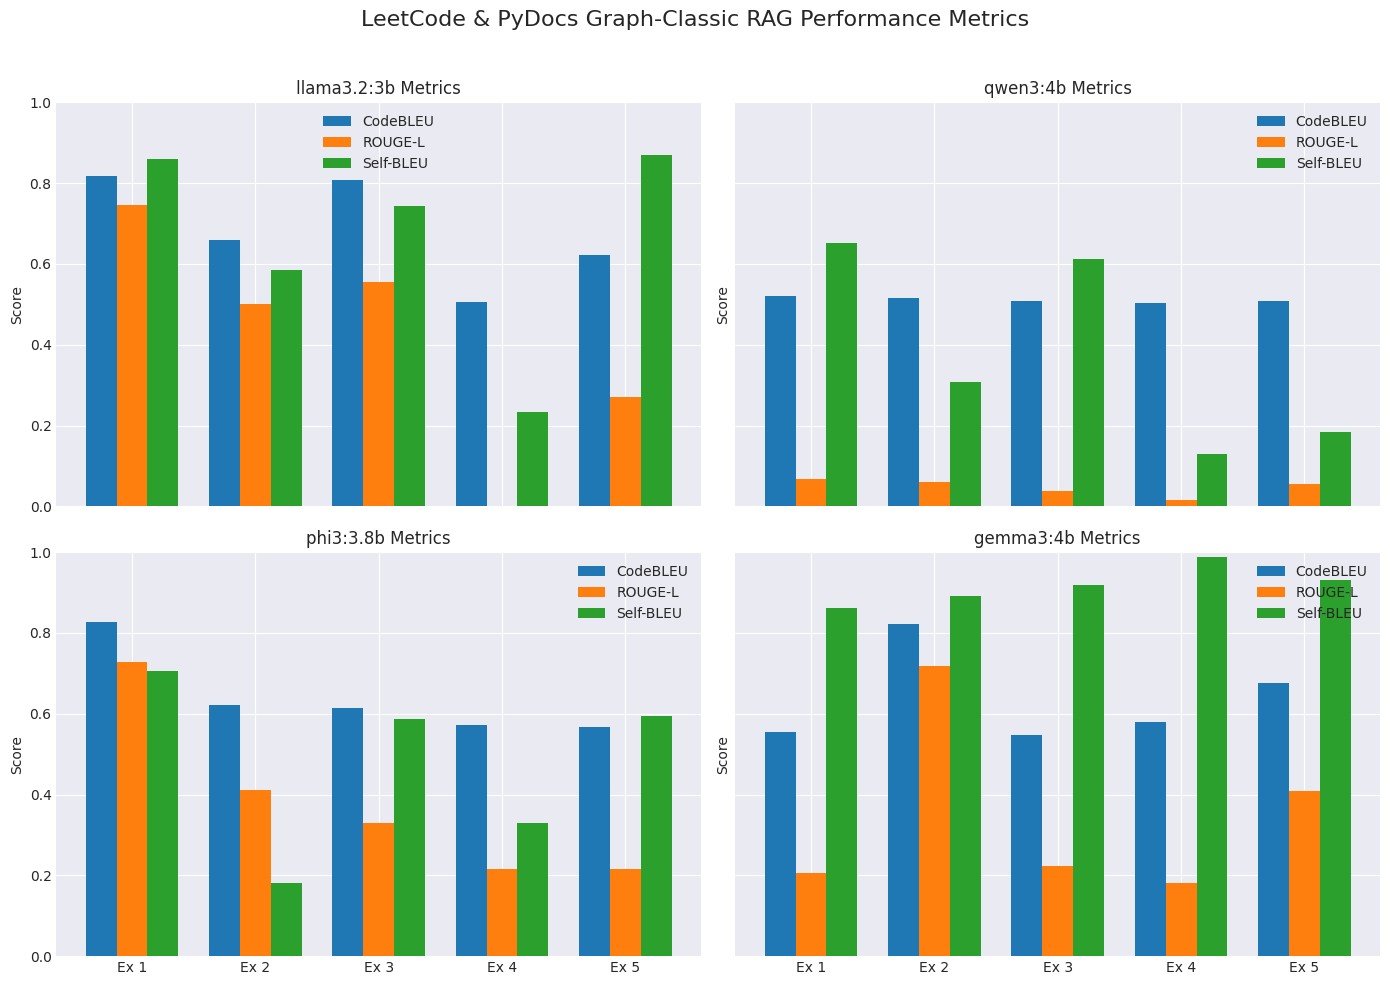

In [213]:
# Plotting the Graph RAG leetcode-only  performance metrics
extracted_metric_scores = extract_metric_scores(benchmark_metrics)
plot_model_metrics(extracted_metric_scores, "LeetCode & PyDocs Graph-Classic RAG Performance Metrics")

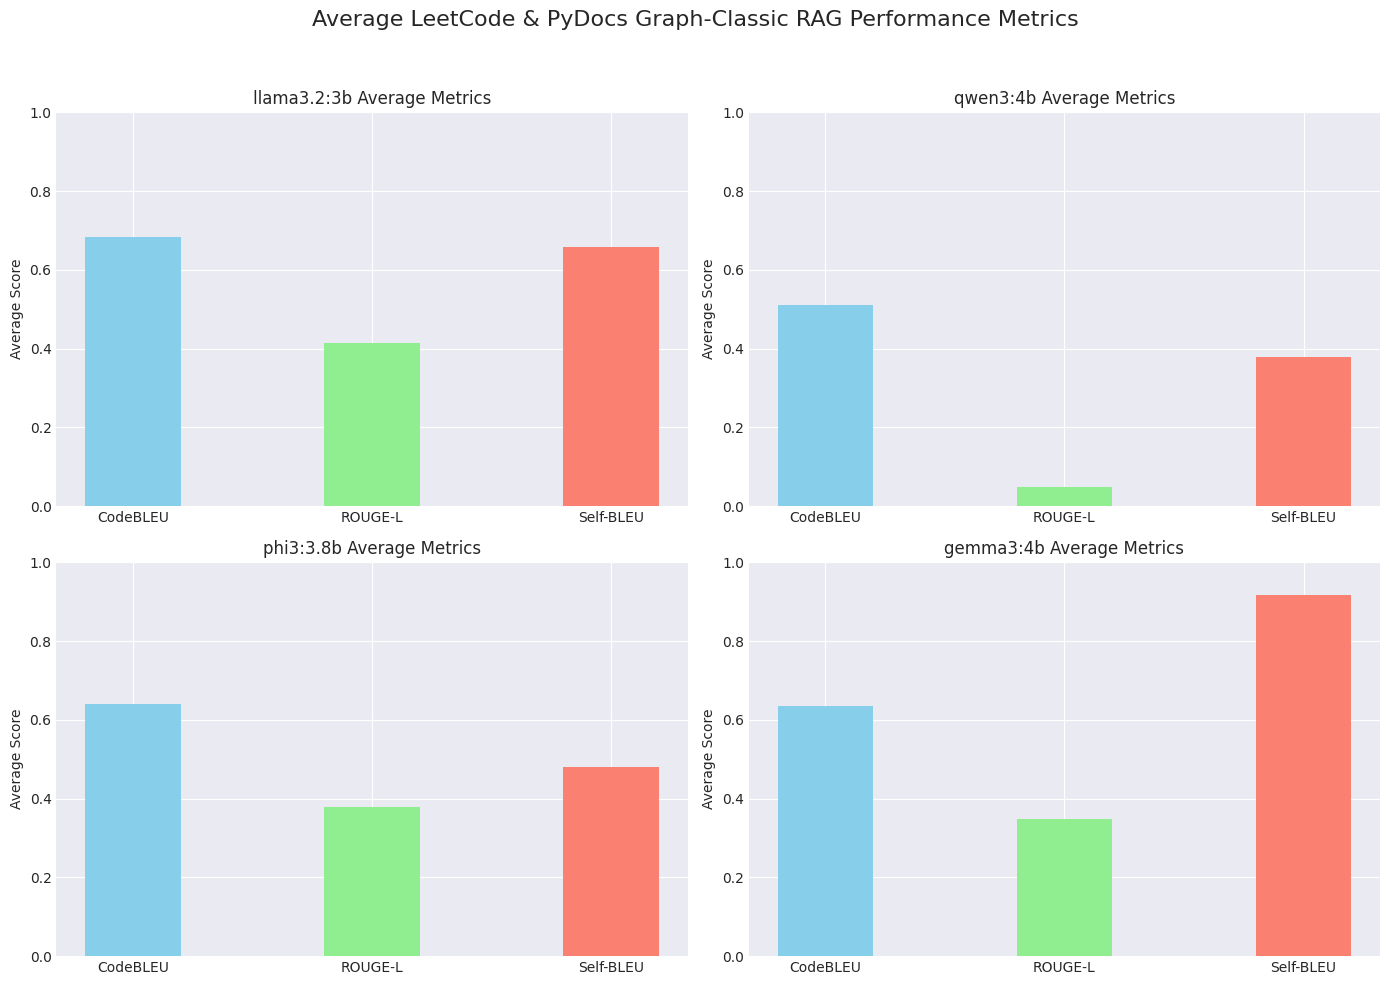

In [214]:
plot_avg_model_metrics(extracted_metric_scores, "Average LeetCode & PyDocs Graph-Classic RAG Performance Metrics")

---

# Conclusions

I Require confirmation from my Advisor in order to fully draw my conclusions, however my personal opinion on the matter is:

- The *best* grounding needed for the setup is that of the ***leetcode*** dataset
- ***Classic*** vector-based RAG and ***Graph RAG*** have similar performances
- As far as heavily ***quantized*** and small models go, ***gemma3*** performs best in this particular task


---